In [366]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (9,6)

In [361]:
def run_stats(exp, skip_rows, mode):
    results = pd.read_csv("stats/"+f"{exp}" + "/results_bkp", delimiter=r":", skiprows = skip_rows, header = None)
    begin = 0
    for idx, row in results.iterrows():
        if row[0].startswith("="):
            begin = idx+1
    results = results[begin:]
    data = {}
    for index, row in results.iterrows():
        data[f'{row[0].strip()}'] = row[1]
    if 'Total RUN' in data:
        if mode == 'onepass':
            data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'] + data['RECORD read'])
        elif mode == 'isolate':
            data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'] + data['RUN read-write'])            
        else:
            data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'])
    if 'Total MERGE' in data:
        if mode == 'mergepass':
            data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'] + data['RECORD read'])
        else: 
            data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'])
    else:
        data['Total MERGE'] = 0
        data['MERGE read'] = 0
        data['MERGE write'] = 0
    return data

## CEMS bandwidth

In [480]:
'''
end_time, OP, time_taken, data_handled (B)
'''
def cems_pmem_bandwdith(exp):
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results", skipfooter = 9, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    # print(pm_df)
    plt.figure()
    plt.xticks(np.arange(0, 100, step=2))
    plt.yticks(np.arange(0, 30.5, step=1))
    plt.ylim(-0.1, 25.5)
    plt.xlim(-0.5, 80)
    plt.plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    plt.fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='red', alpha=.6)
    # Max read bandwidth
    plt.axhline(y=22, color='r', linestyle='--')
    plt.annotate('Max read bw', (70, 23), color='r')
    plt.plot(pm_df['time'], pm_df['write_bw'], color='black', label="write bw")
    plt.fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='black', alpha=.6)
    # Max write bandwidth
    plt.axhline(y=6.6, color='black', linestyle='--')
    plt.annotate('Max write bw', (70, 7.4))
    plt.grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1)
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    plt.axvspan(0 ,4.5 + run_time, color='orange', alpha=0.2)
    plt.axvspan(4.5 + run_time, 5.5 + run_time + merge_time, color='cornflowerblue', alpha=0.2)
    plt.annotate('RUN', (1, 24), color="orange")
    plt.annotate('MERGE', (5 + run_time, 24), color="cornflowerblue")
    plt.xlabel("Time (s)")
    plt.ylabel("PMEM bandwdith (GB/s)")
    plt.title(exp)

    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

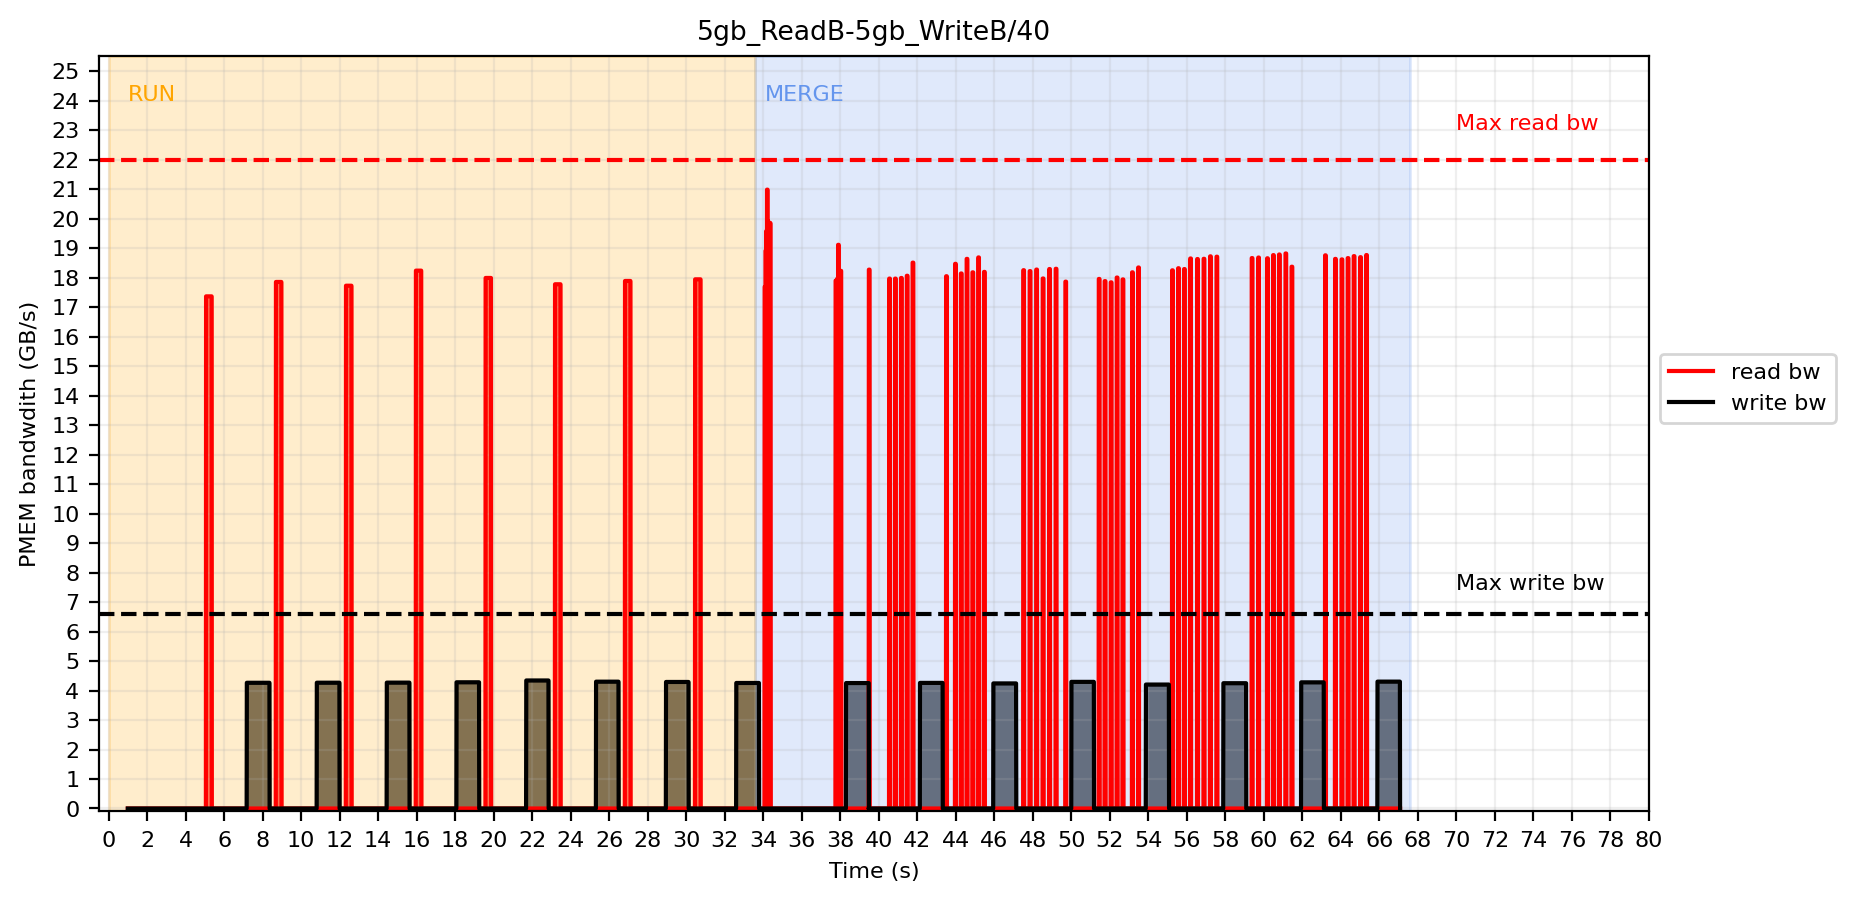

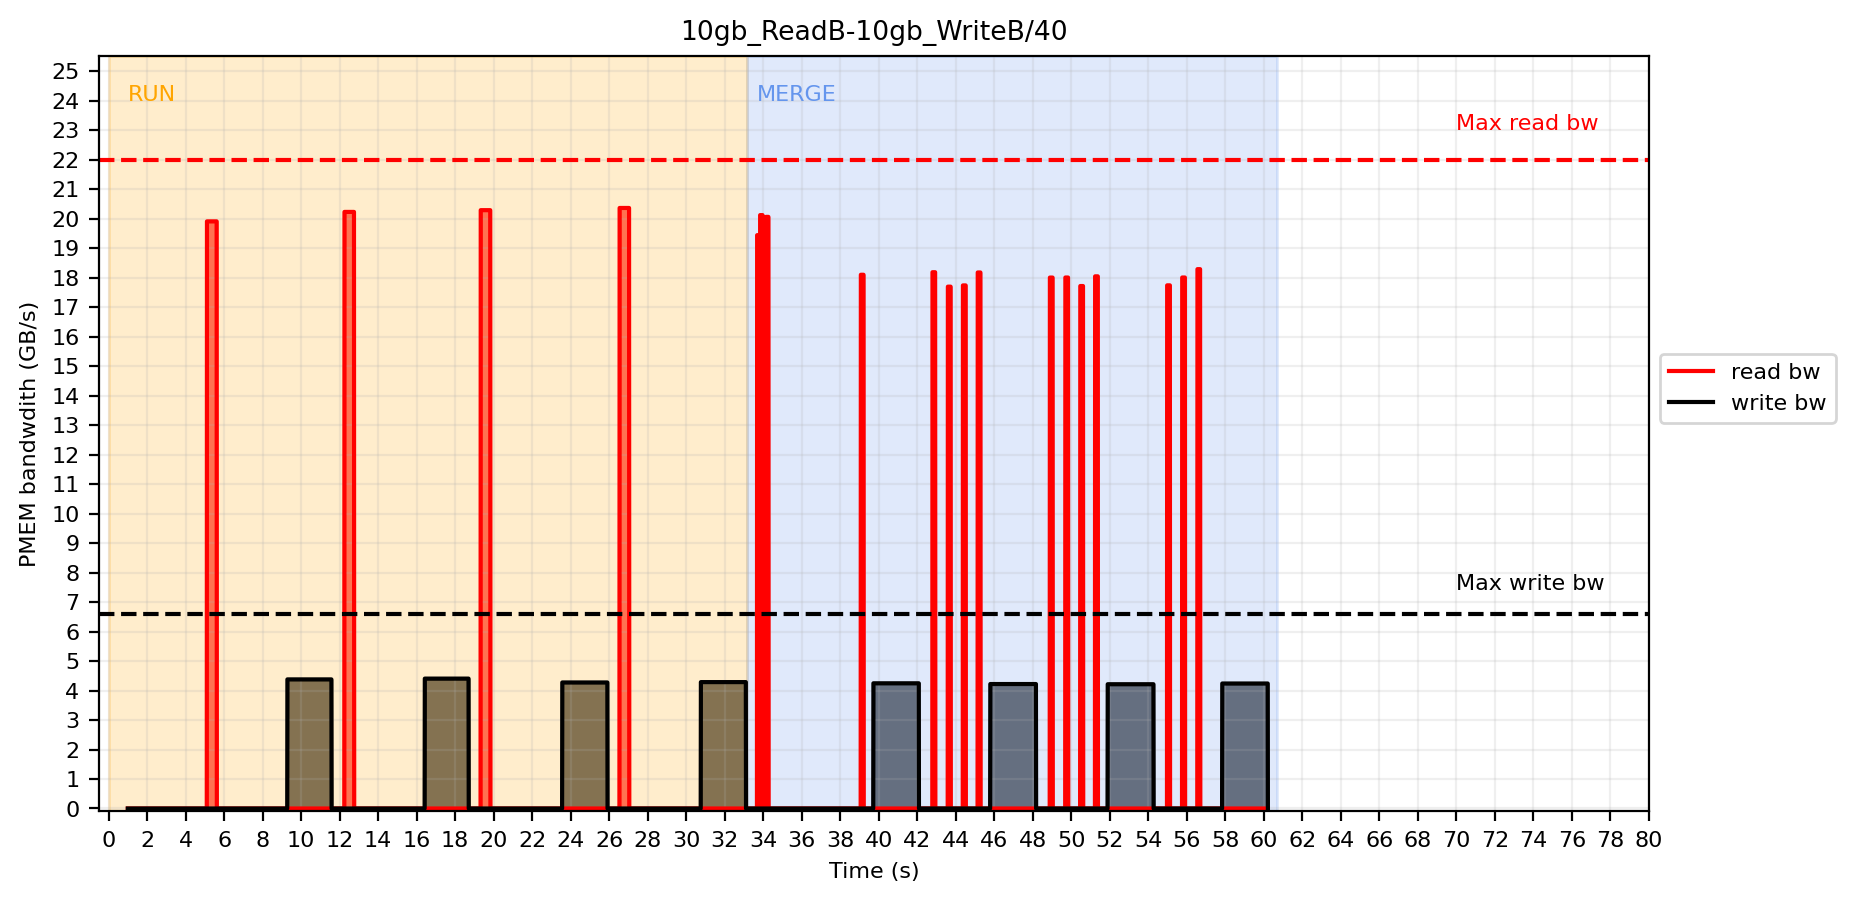

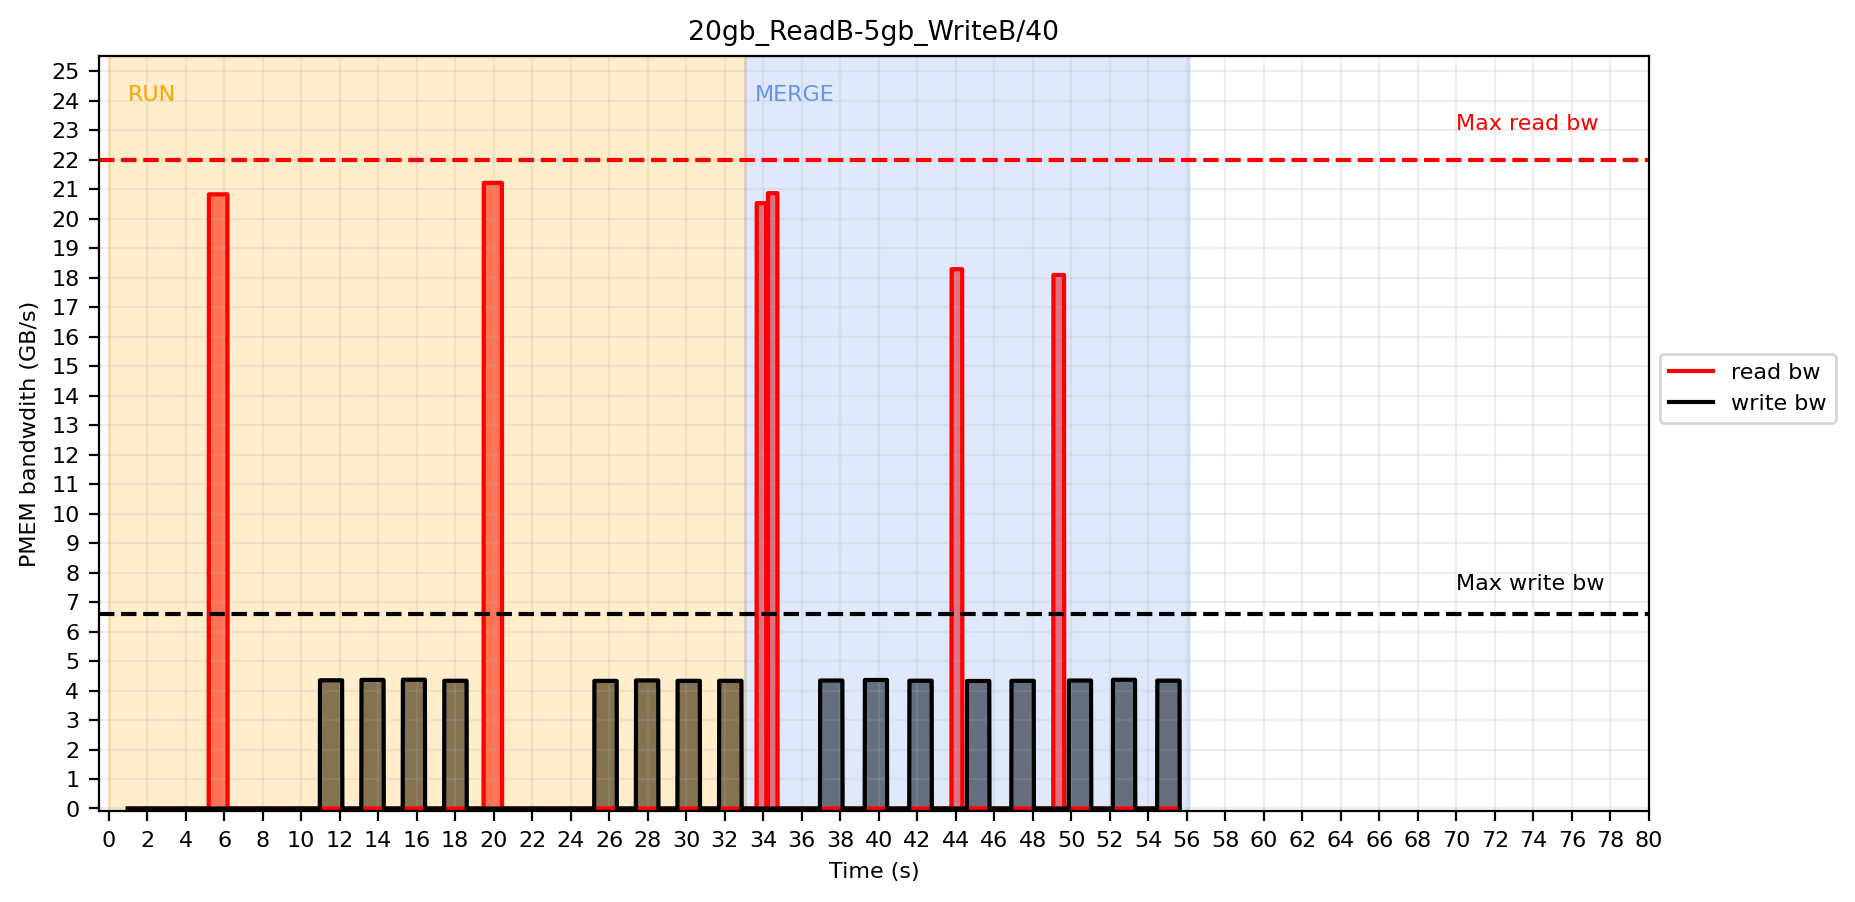

In [481]:
cems_pmem_bandwdith('5gb_ReadB-5gb_WriteB/40')
cems_pmem_bandwdith('10gb_ReadB-10gb_WriteB/40')
cems_pmem_bandwdith('20gb_ReadB-5gb_WriteB/40')

## WISC bandwidth

In [479]:
'''
end_time, OP, time_taken, data_handled (B)
'''
def wisc_pmem_bandwdith(exp):
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results", skipfooter = 5, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
        if row[1] =='READ-WRITE':
            read_bw = data_gb/row[2]
            write_bw = data_gb/row[2]
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    # print(pm_df)
    plt.figure()
    plt.xticks(np.arange(0, 100, step=5))
    plt.yticks(np.arange(0, 30.5, step=1))
    plt.ylim(-0.1, 25.5)
    plt.xlim(-0.5, 90)
    plt.plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    # Max read bandwidth
    plt.axhline(y=22, color='r', linestyle='--', label="Max read bw")
    plt.plot(pm_df['time'], pm_df['write_bw'], color='black', label="write bw")
    # Max write bandwidth
    plt.axhline(y=6.6, color='black', linestyle='--', label="Max write bw")
    plt.grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1)
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    plt.axvspan(0 ,run_time, color='orange', alpha=0.2, label = "RUN")
    plt.axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2, label = "MERGE")
    plt.xlabel("Time (s)")
    plt.ylabel("PMEM bandwdith (GB/s)")
    plt.title(exp)

    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

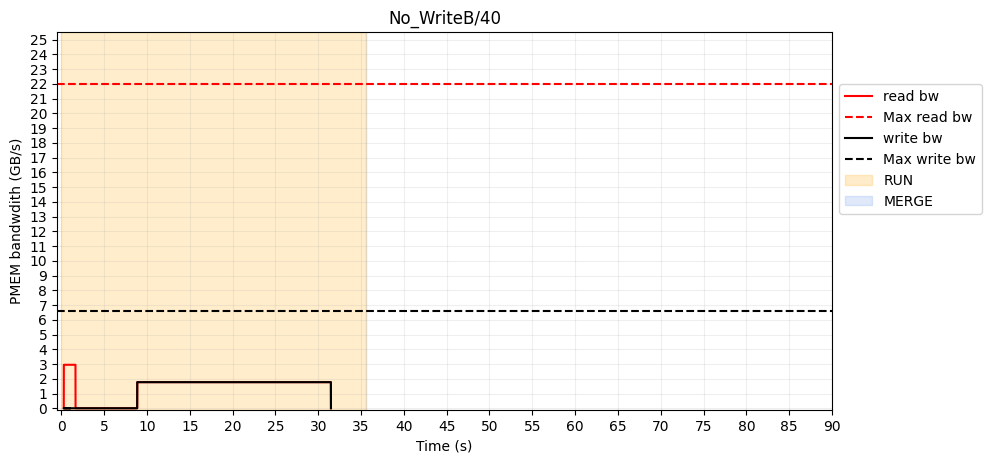

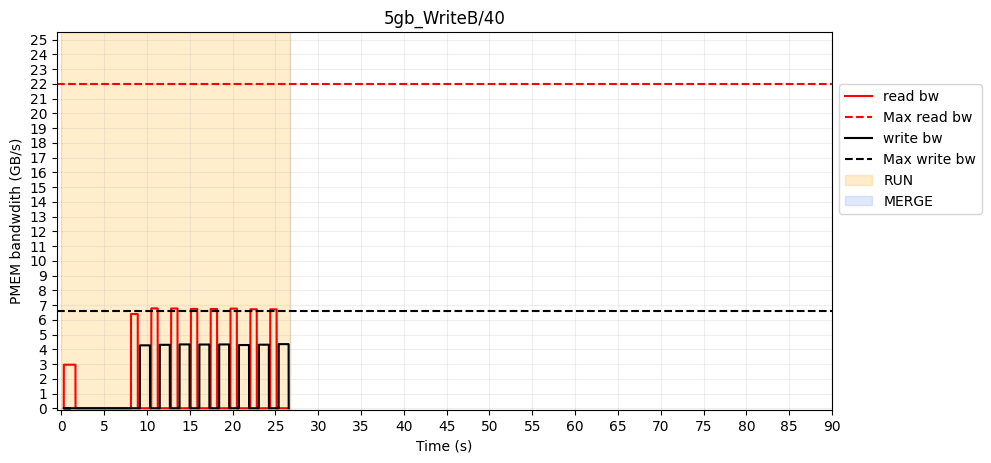

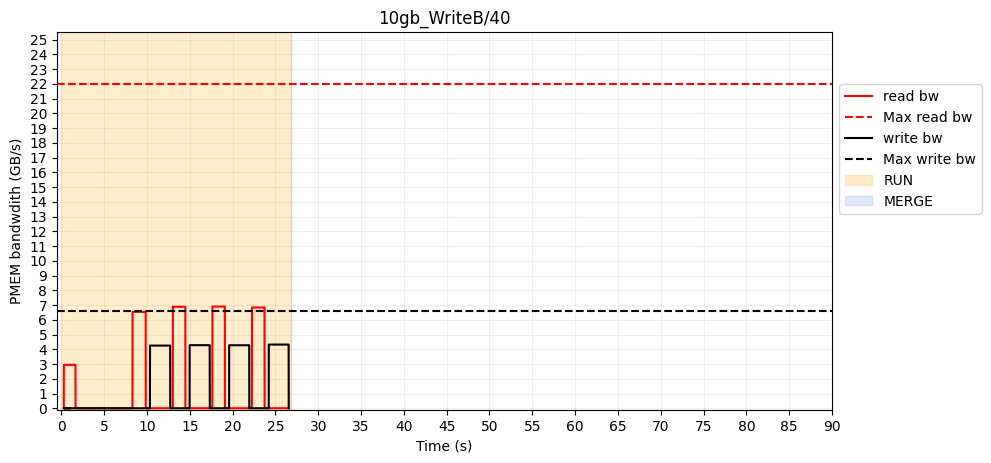

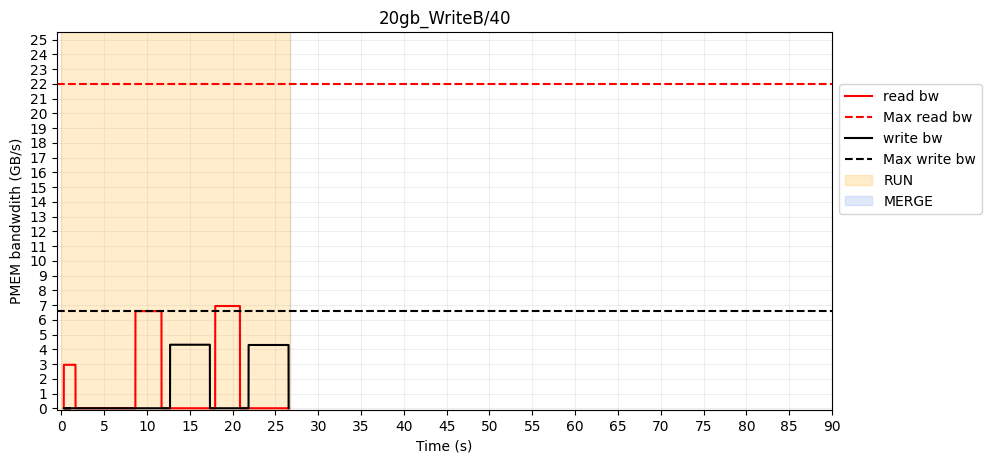

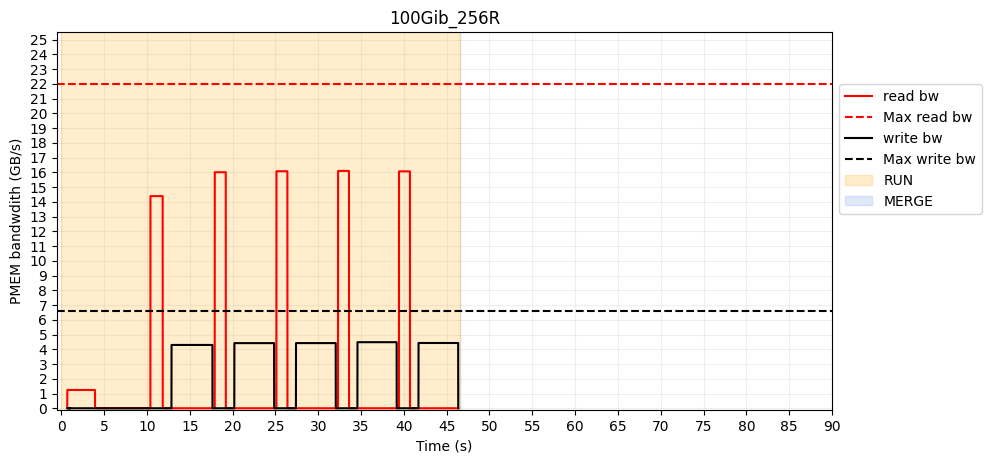

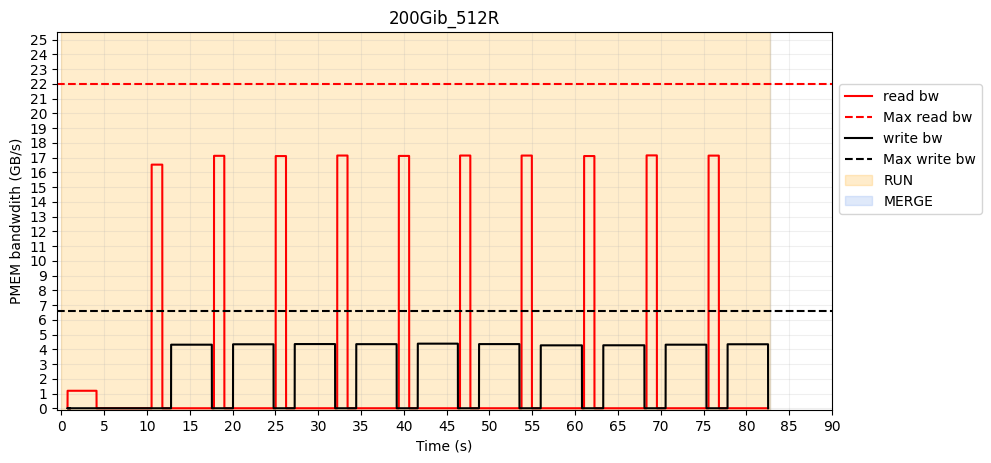

In [223]:
wisc_pmem_bandwdith('No_WriteB/40')
wisc_pmem_bandwdith('5gb_WriteB/40')
wisc_pmem_bandwdith('10gb_WriteB/40')
wisc_pmem_bandwdith('20gb_WriteB/40')
wisc_pmem_bandwdith('100Gib_256R')
wisc_pmem_bandwdith('200Gib_512R')

## WISC V:K graphs

In [237]:
## Subplots of same graph
def run_stats(exp, sort, skip_rows):
    results = pd.read_csv("stats/VKratio/"+ f"{exp}/{sort}" + "/results", delimiter=r":", skiprows = skip_rows, header = None)
    begin = 0
    for idx, row in results.iterrows():
        if row[0].startswith("="):
            begin = idx+1
    results = results[begin:]
    data = {}
    for index, row in results.iterrows():
        data[f'{row[0].strip()}'] = row[1]
    if 'Total RUN' in data:
        data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'])
    if 'Total MERGE' in data:
        data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'])
    else:
        data['Total MERGE'] = 0
        data['MERGE read'] = 0
        data['MERGE write'] = 0
    return data

In [249]:
def wisc_pmem_bandwdith_subplots(exps,sort):
    fig,ax =  plt.subplots(2, len(exps)//2, sharex=True, sharey=True,)
    i = 0; # row
    j = 0; # column
    comp = (len(exps)//2)-1
    for idx,exp in enumerate(exps):
        pmem_pd = pd.read_csv("stats/VKratio/"+ f"{exp}/{sort}" + "/results", skipfooter = 5, delimiter=r",", engine='python', header=None)
        pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
        pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
        for index, row in pmem_pd.iterrows():
            read_bw = 0
            write_bw = 0
            data_gb = row[3] * 1.0e-9
            if row[1] == 'READ':
                read_bw = data_gb/row[2]
            if row[1] == 'WRITE':
                write_bw = data_gb/row[2]
            if row[1] =='READ-WRITE':
                read_bw = data_gb/row[2]
                write_bw = data_gb/row[2]
            pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
            pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)

        ax[i][j].set_xticks(np.arange(0, 100, step=2))
        ax[i][j].set_yticks(np.arange(0, 30.5, step=5))
        ax[i][j].set_ylim(-0.1, 30.5)
        ax[i][j].set_xlim(-0.5, 20)
        ax[i][j].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
        # Max read bandwidth
        ax[i][j].axhline(y=22.5, color='r', linestyle='--', label="Max read bw")
        ax[i][j].plot(pm_df['time'], pm_df['write_bw'], color='black', label="write bw")
        # Max write bandwidth
        ax[i][j].axhline(y=6.6, color='black', linestyle='--', label="Max write bw")
        ax[i][j].grid(alpha=0.2)

        # Run and merge stage indicators
        data = run_stats(exp,sort,len(pmem_pd.index)+1)
        run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
        merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
        ax[i][j].axvspan(0, run_time, color='orange', alpha=0.2, label = "RUN")
        ax[i][j].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2, label = "MERGE")
        ax[i][j].set_title(f"{exp.split('_')[1]}:{exp.split('_')[0]}")
        if idx < comp:
            j+=1
        else:
            i+= 1
            comp = (comp * 2)+1
            j = 0
    fig.text(0.5, 0.0, 'Time (s)', ha='center')
    fig.text(0.0, 0.5, 'PMEM bandwdith (GB/s)', va='center', rotation='vertical')            
    plt.tight_layout()

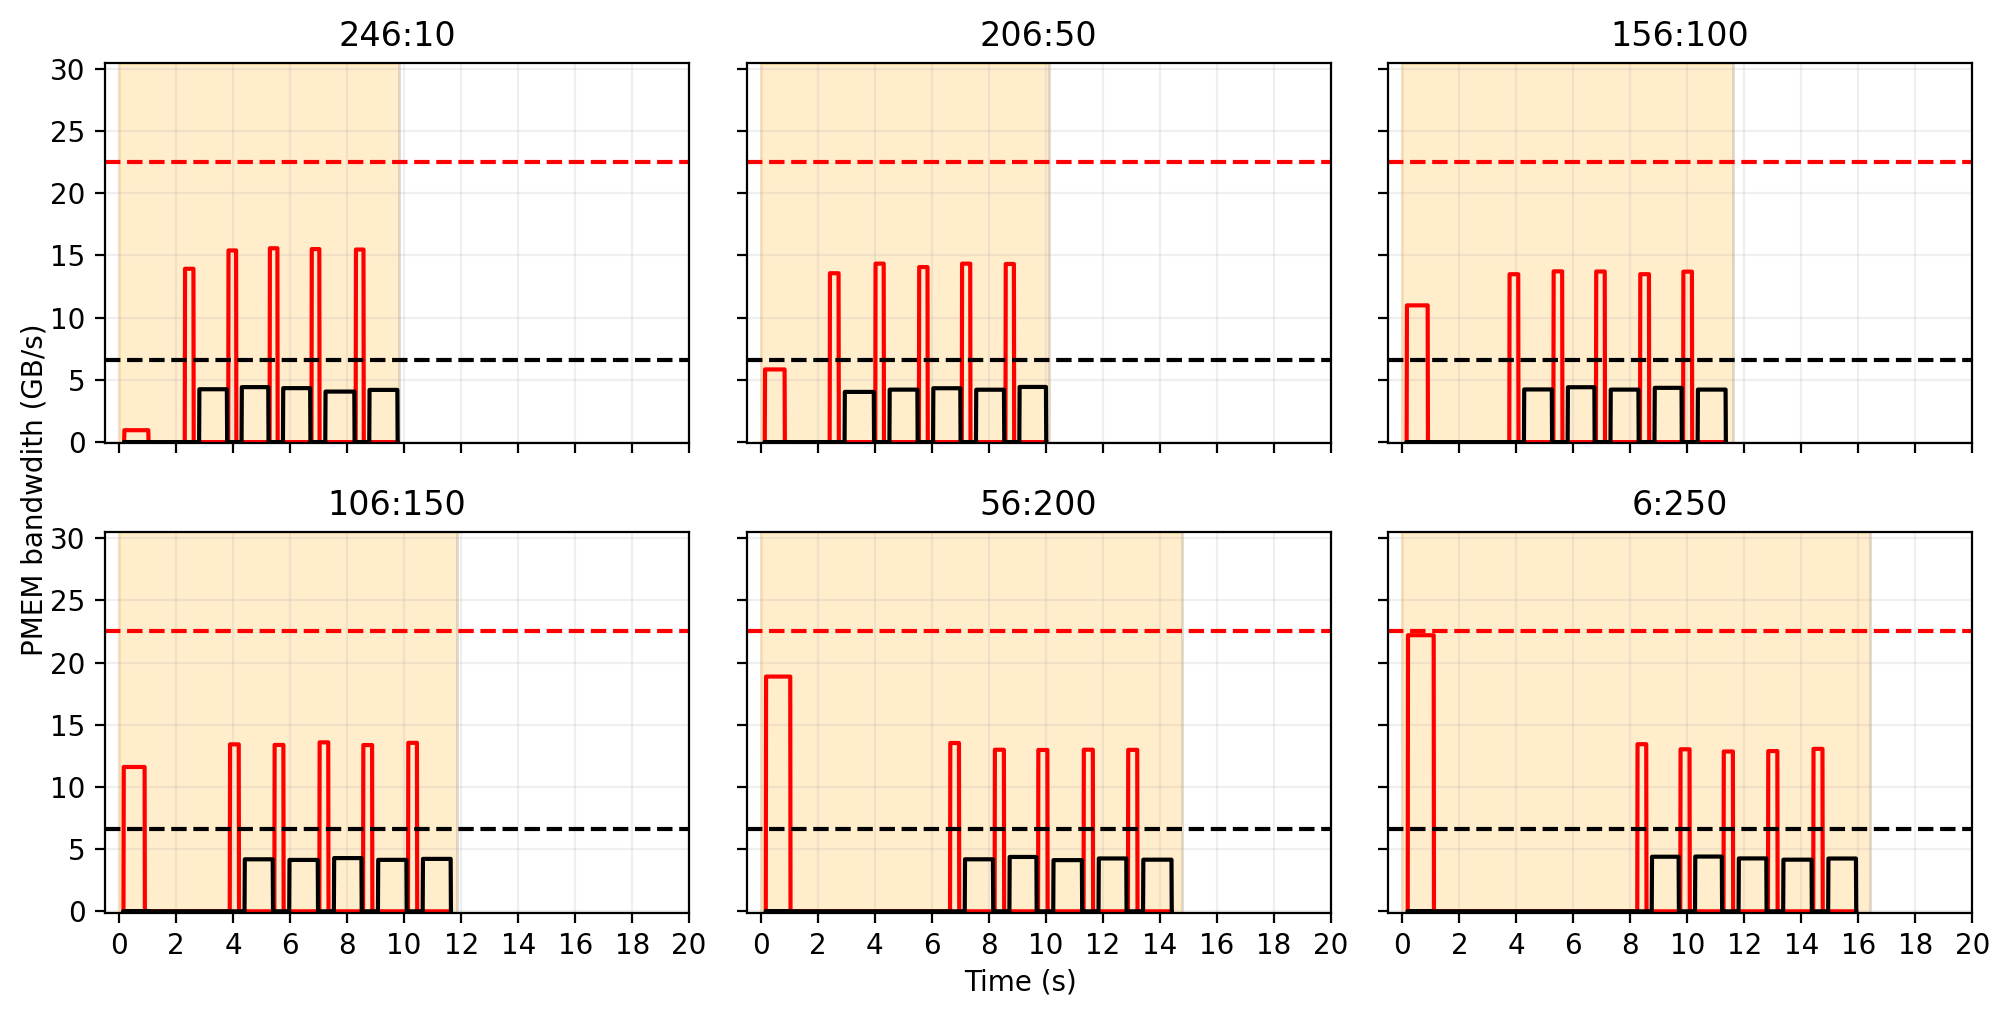

In [250]:
wisc_pmem_bandwdith_subplots(['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'], 'WiscSort')

## CEMS V:K graph

In [251]:
def cems_pmem_bandwdith_subplots(exps,sort):
    fig,ax =  plt.subplots(2, len(exps)//2, sharex=True, sharey=True,)
    i = 0; # row
    j = 0; # column
    comp = (len(exps)//2)-1
    for idx,exp in enumerate(exps):
        pmem_pd = pd.read_csv("stats/VKratio/"+ f"{exp}/{sort}" + "/results", skipfooter = 9, delimiter=r",", engine='python', header=None)
        pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
        pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
        for index, row in pmem_pd.iterrows():
            read_bw = 0
            write_bw = 0
            data_gb = row[3] * 1.0e-9
            if row[1] == 'READ':
                read_bw = data_gb/row[2]
            if row[1] == 'WRITE':
                write_bw = data_gb/row[2]
            if row[1] =='READ-WRITE':
                read_bw = data_gb/row[2]
                write_bw = data_gb/row[2]
            pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
            pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)

        ax[i][j].set_xticks(np.arange(0, 100, step=5))
        ax[i][j].set_yticks(np.arange(0, 30.5, step=5))
        ax[i][j].set_ylim(-0.1, 30.5)
        ax[i][j].set_xlim(-0.5, 40)
        ax[i][j].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
        # Max read bandwidth
        ax[i][j].axhline(y=22.5, color='r', linestyle='--', label="Max read bw")
        ax[i][j].plot(pm_df['time'], pm_df['write_bw'], color='black', label="write bw")
        # Max write bandwidth
        ax[i][j].axhline(y=6.6, color='black', linestyle='--', label="Max write bw")
        ax[i][j].grid(alpha=0.2)

        # Run and merge stage indicators
        data = run_stats(exp,sort,len(pmem_pd.index)+1)
        run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
        merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
        ax[i][j].axvspan(0 ,4.5 + run_time, color='orange', alpha=0.2, label = "RUN")
        ax[i][j].axvspan(4.5 + run_time, 5.5 + run_time + merge_time, color='cornflowerblue', alpha=0.2, label = "MERGE")
        ax[i][j].set_title(f"{exp.split('_')[1]}:{exp.split('_')[0]}")
        if idx < comp:
            j+=1
        else:
            i+= 1
            comp = (comp * 2)+1
            j = 0
    fig.text(0.5, 0.0, 'Time (s)', ha='center')
    fig.text(0.0, 0.5, 'PMEM bandwdith (GB/s)', va='center', rotation='vertical')            
    plt.tight_layout()

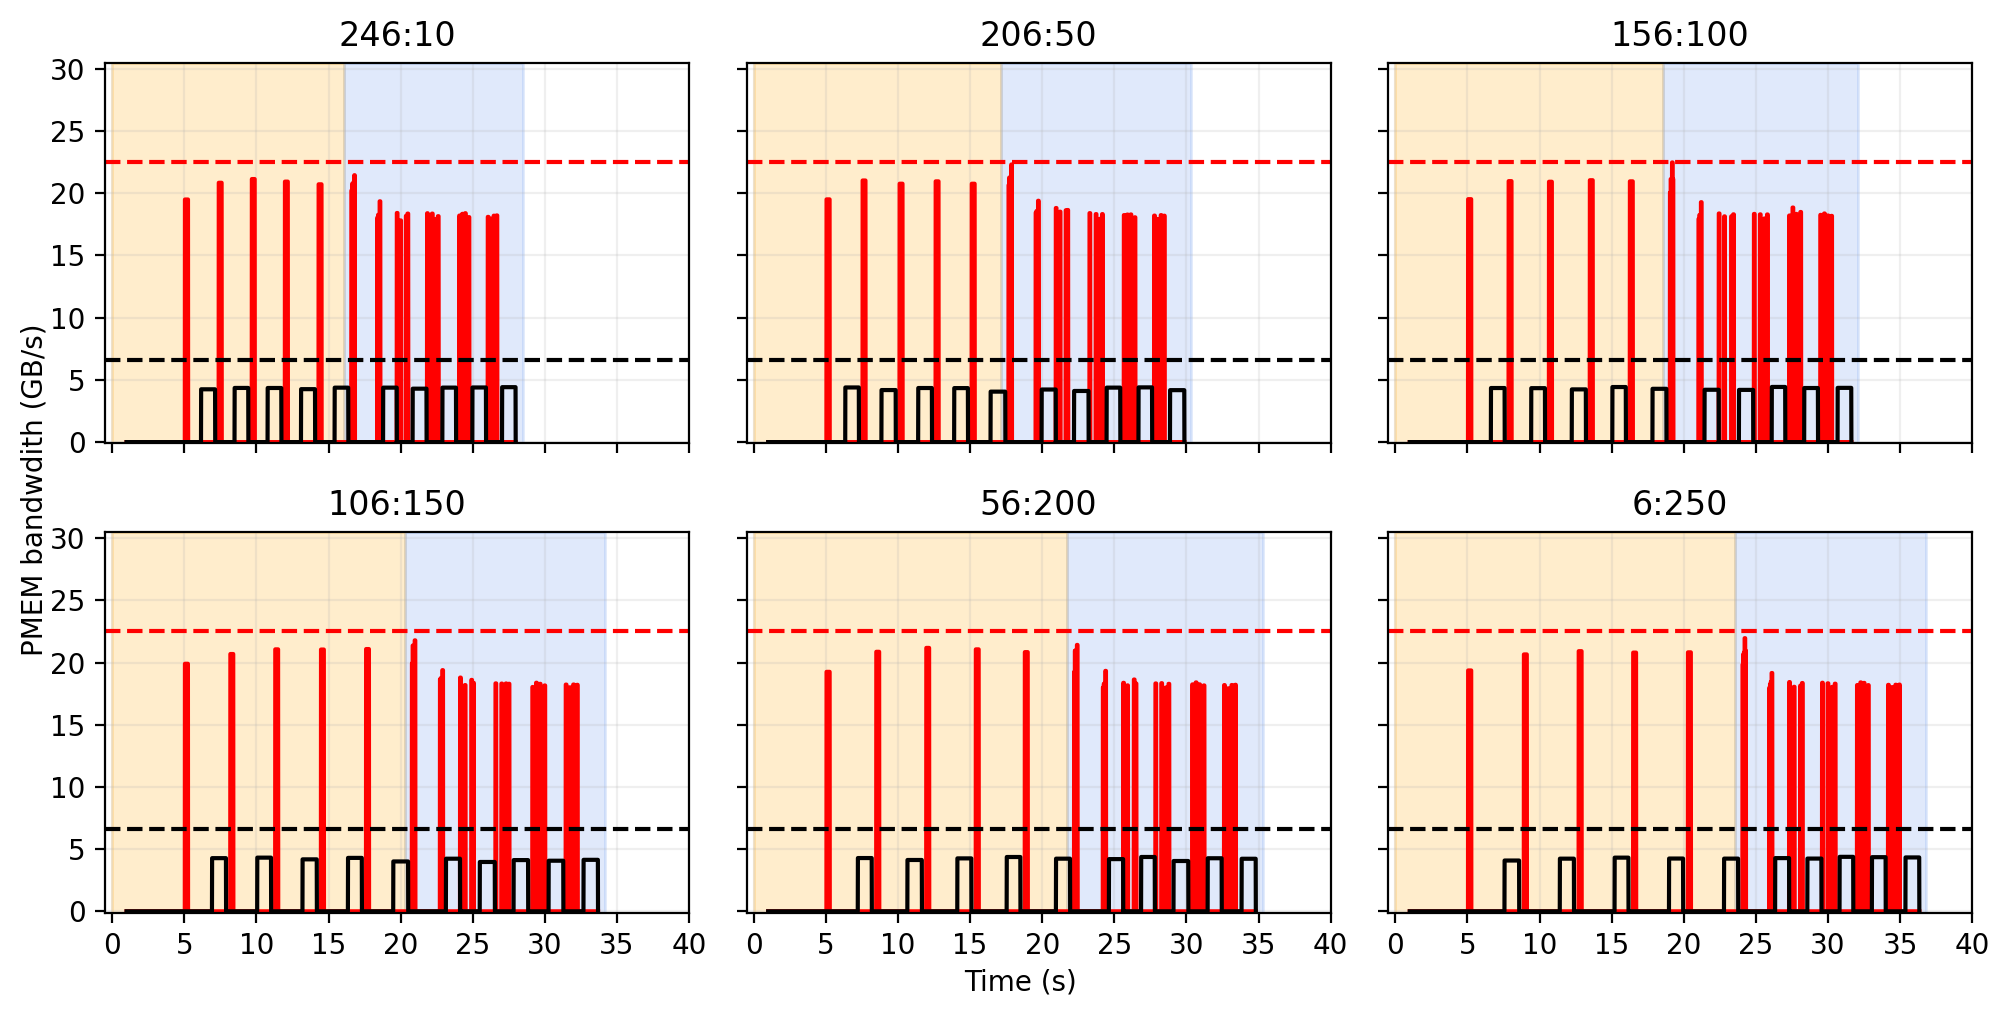

In [252]:
cems_pmem_bandwdith_subplots(['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'], 'CEMS')

## K:V grouped stacked bar

In [792]:
df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
            
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i*2 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
    
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.grid(alpha=0.22)
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0,260, 2))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("K:V ratios")
    axe.set_ylabel("Time (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))
    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'Total RUN', 'MERGE read', 'MERGE write', 'Total MERGE']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            skip_rows = 0
            n_rows = sum(1 for row in open("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", 'r'))
            if exp == 'CEMS':
                skip_rows = n_rows + 1 - 9
            if exp == 'WiscSort':
                skip_rows = n_rows + 1 - 5
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":",skiprows = skip_rows, header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [f"{dnum.split('_')[0]}:{dnum.split('_')[1]}"]
            
            df = pd.concat([df, results])
        send.append(df)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)

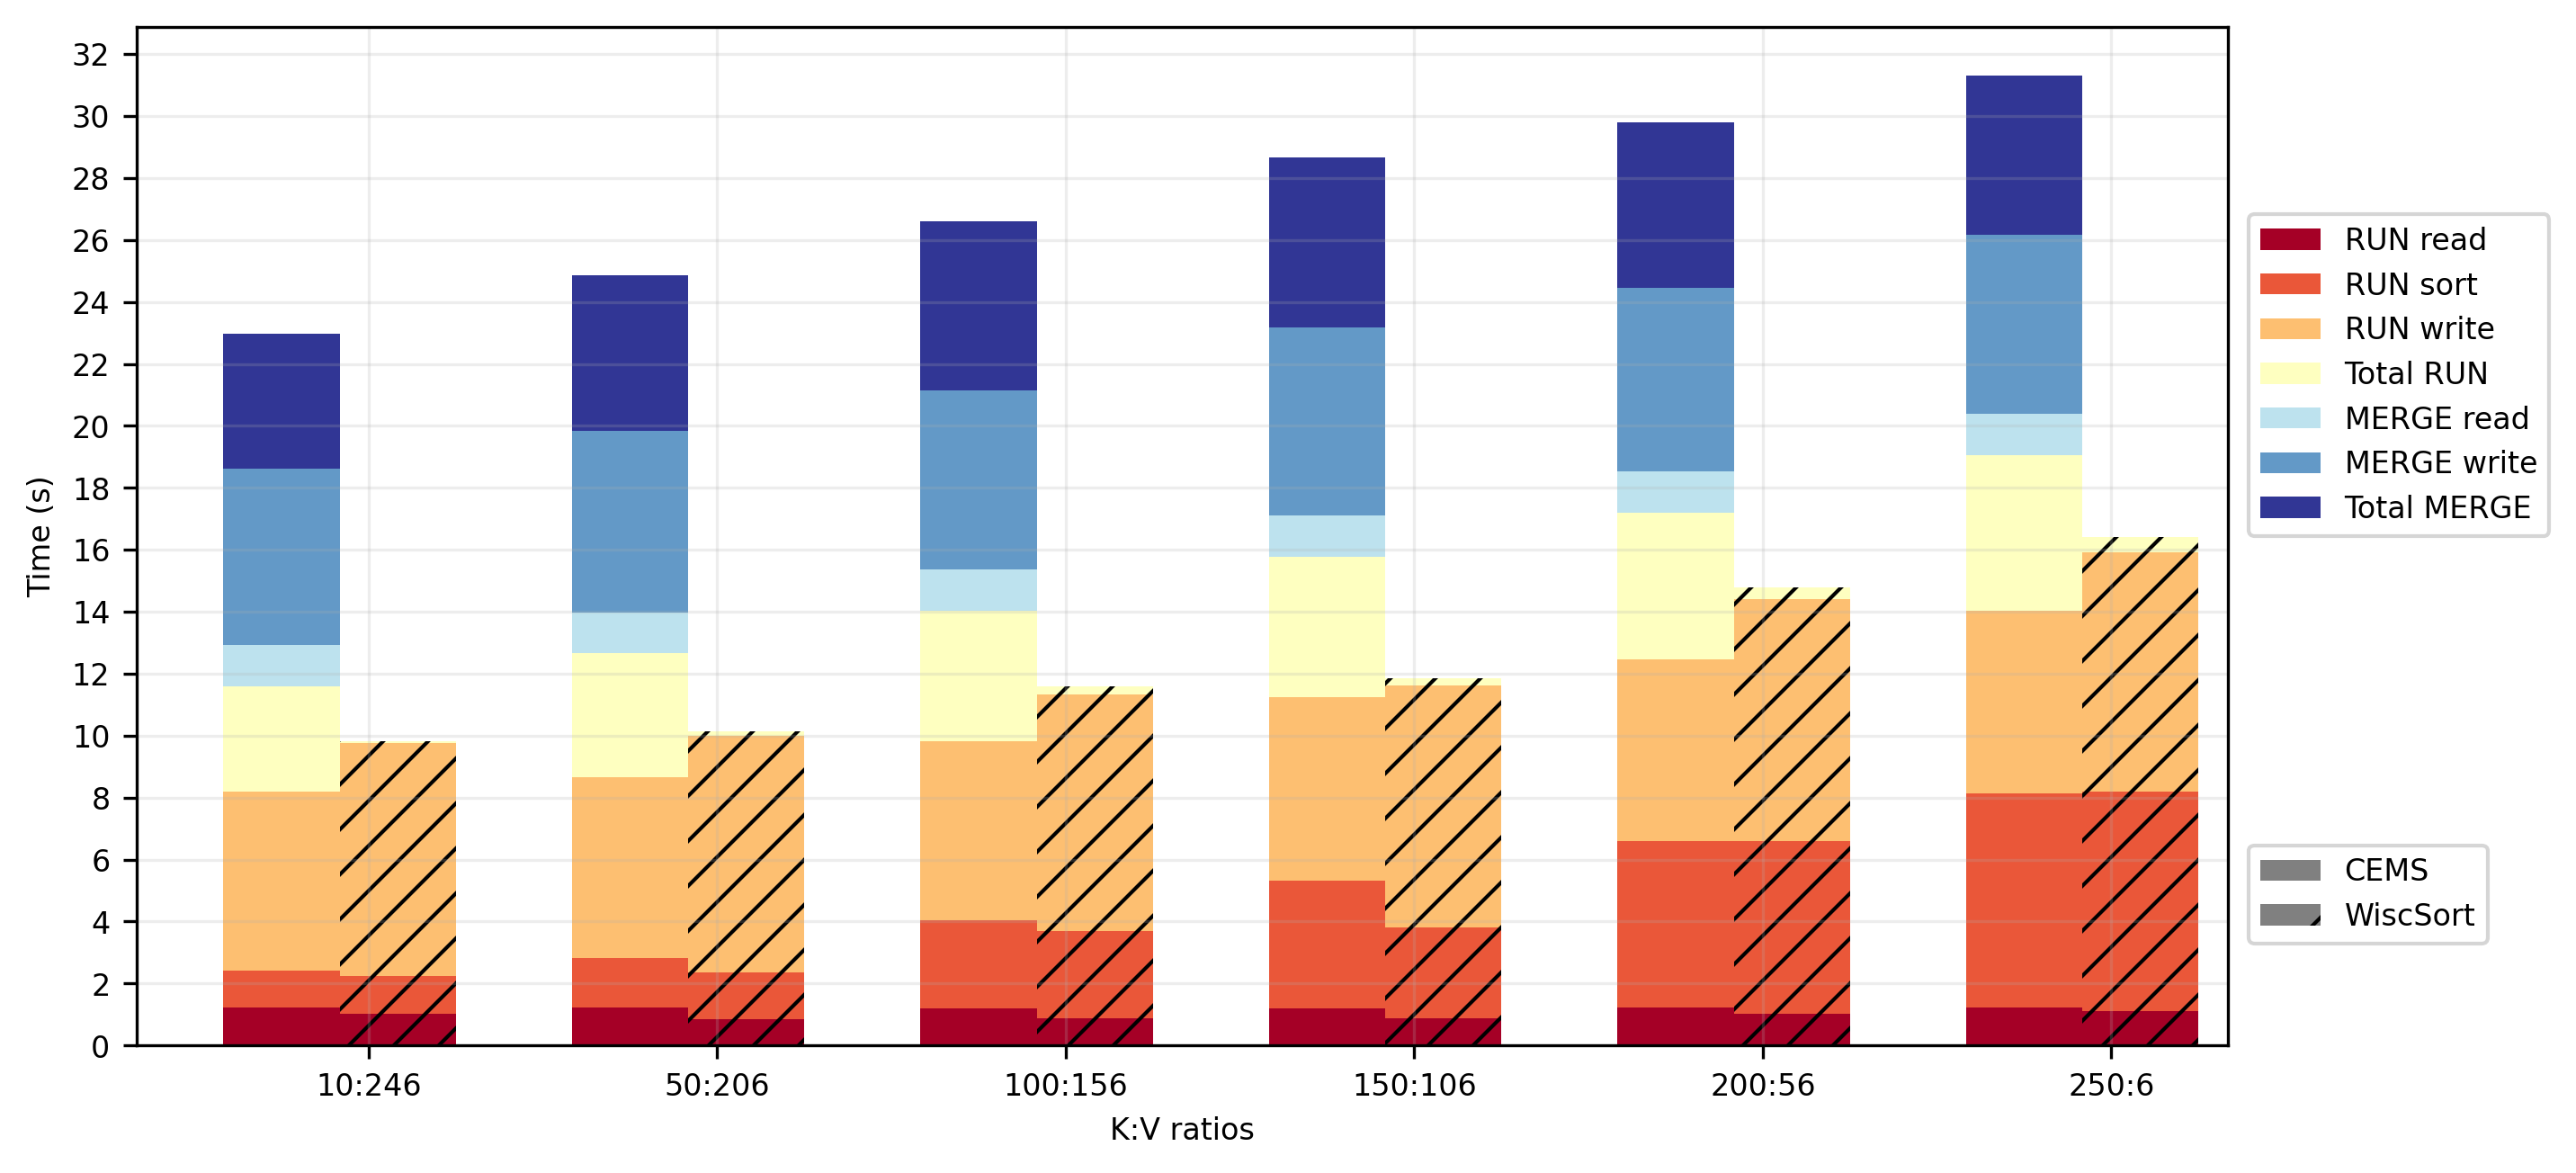

In [793]:
stacked_bar_runtime('VKratio',['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'], ['CEMS', 'WiscSort'])

In [345]:
def wiscSort_cems_improv(folder, iters):
    xlabels = []
    speedup_percent = []
    speedup = []
    for dnum in iters:
        xlabels.append(f"{dnum.split('_')[0]}:{dnum.split('_')[1]}")
        # get both exps values for the experiment
        n_rows = sum(1 for row in open("stats/"+f"{folder}/{dnum}/"+"CEMS" + "/results", 'r'))
        skip_rows = n_rows + 1 - 9
        cems_results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+"CEMS" + "/results", delimiter=r":",skiprows = skip_rows, header = None)
        n_rows = sum(1 for row in open("stats/"+f"{folder}/{dnum}/"+"WiscSort" + "/results", 'r'))
        skip_rows = n_rows + 1 - 5
        wisc_results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+"WiscSort" + "/results", delimiter=r":",skiprows = skip_rows, header = None)
        tmp = ((cems_results[1][7] - wisc_results[1][3])/cems_results[1][7]) * 100
        speedup_percent.append(tmp)
        speedup.append(cems_results[1][7] / wisc_results[1][3])
    plt.bar(xlabels, speedup,color='gray')
    plt.grid(alpha=0.3, axis='y')
    plt.xlabel("K:V ratios")
    plt.ylabel("WiscSort Speedup")
    print(speedup)
    print(speedup_percent)
    print(xlabels)

[2.3408450173068216, 2.4541912185497363, 2.2966635339319366, 2.41991348238587, 2.0147971256460546, 1.9098728026840832]
[57.28038410887555, 59.253378773356815, 56.45857631187366, 58.676208580231226, 50.36721130524021, 47.640492152428834]
['10:246', '50:206', '100:156', '150:106', '200:56', '250:6']


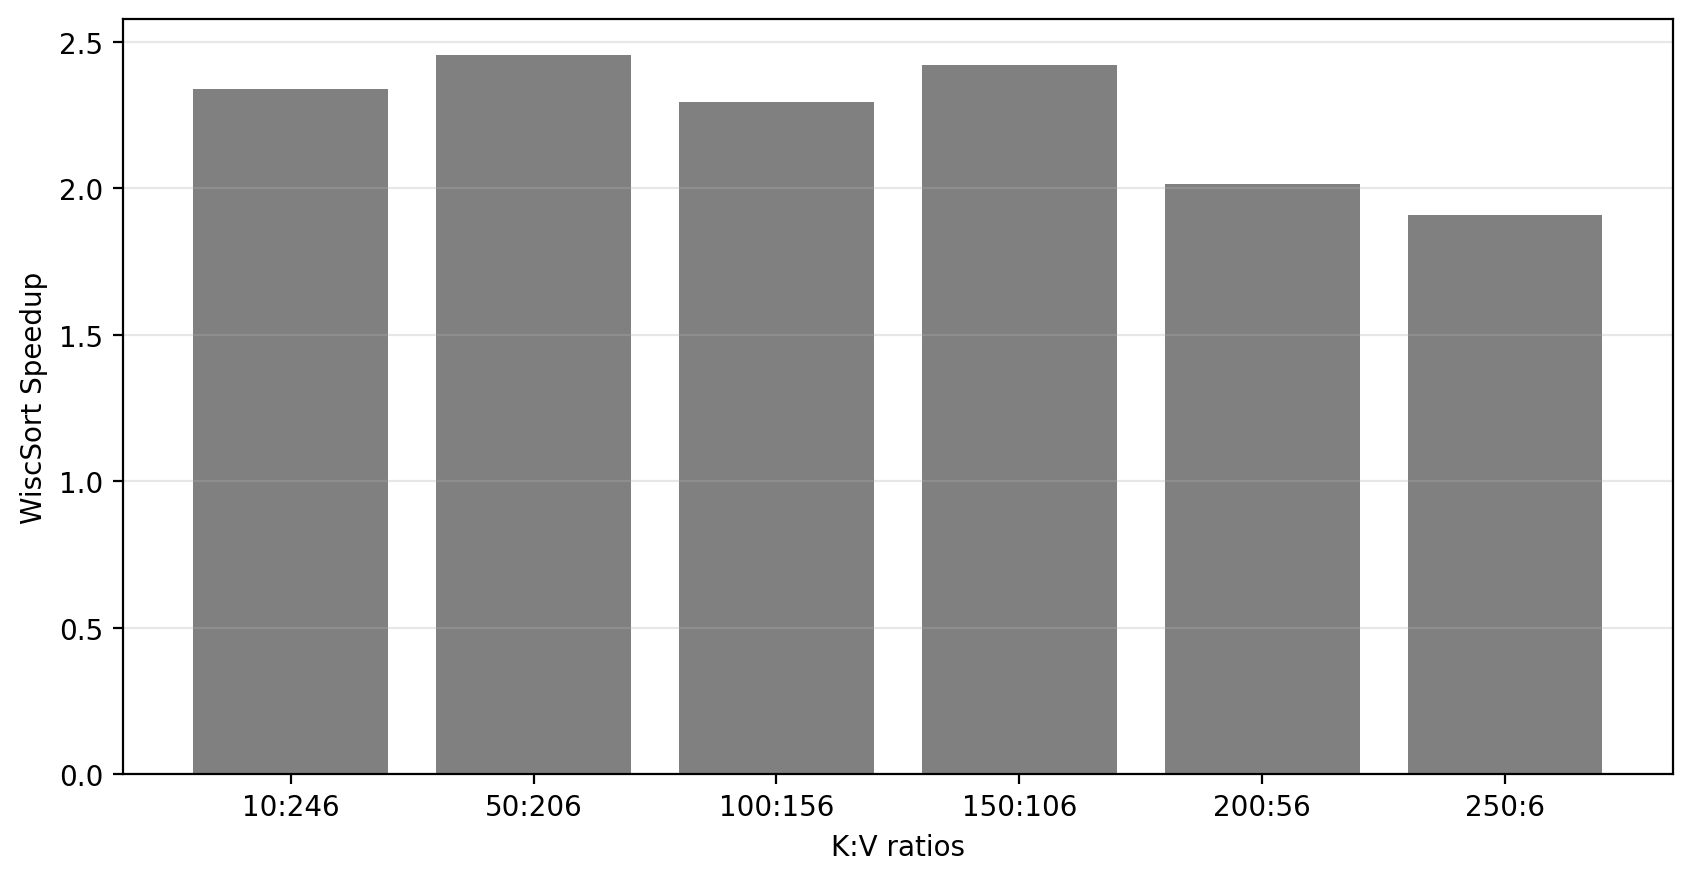

In [346]:
wiscSort_cems_improv('VKratio',['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'])

## CEMS IO efficiency

In [364]:
plt.rcParams.update({'font.size': 12})
def cems_io_efficiency_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results_bkp", skipfooter = 9, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_tak en', 'data', 'read_bw', 'write_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    plt.figure()
    # 160 GB
    ax[0].set_xticks(np.arange(0, 360, step=20))
    ax[0].set_xlim(-0.5, 340)
    # 40 GB
    # ax[0].set_xticks(np.arange(0, 60, step=5))
    # ax[0].set_xlim(-0.5, 55)
    
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='firebrick', label="read bw")
    print(pm_df['read_bw'])
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='firebrick', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='firebrick', linestyle='--', alpha=0.6)
    # 160 gb
    ax[0].annotate('Max seq. read bw', (262, 23), color='firebrick')
    # 40
    # ax[0].annotate('Max seq. read bw', (41, 23), color='firebrick')
    
    ax[1].set_yticks(np.arange(0, 10.5, step=2))
    # ax[1].set_ylim(-0.1, 25.5)
    ax[1].set_ylim(-0.1, 8)
    ax[1].plot(pm_df['time'], pm_df['write_bw'], color='seagreen', label="write bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='seagreen', alpha=.6)
    # Max write bandwidth
    ax[1].axhline(y=5.5, color='seagreen', linestyle='--', alpha=0.6)
    # 160
    ax[1].annotate('Max write bw', (280, 6),  color='seagreen')
    # 40
    # ax[1].annotate('Max write bw', (43, 6),  color='seagreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1, 'cems')
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 22.5), color="orange", weight='bold', alpha=0.8)
            ax[i].annotate('MERGE', ( 1 + run_time, 22.5), color="cornflowerblue", weight='bold',alpha=0.8)    
        
    # CPU utilization
    ax[2].set_yticks(np.arange(0, 100.5, step=25))
    ax[2].set_ylim(-0.1, 102)
    cpu_pd = pd.read_csv("stats/"+ f"{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
    first_time = cpu_pd['epoch'][0] + 0 # + 10 # 10 second sleep ############# NO NEED SINCE NOT USING PMU counters
    cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
     # because only using 20 cores, normalize values
    cpu_pd['usr'] = cpu_pd['usr'].map(lambda x: (x/62.5) * 100)
    cpu_pd['sys'] = cpu_pd['sys'].map(lambda x: (x/62.5) * 100)
    cpu_pd['total'] = cpu_pd.apply(lambda x: x['usr'] + x['sys'], axis=1)
    plt.figure()
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['jkusr'], lw=2, label = "usr")
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['sys'], lw=2, label = "sys")
    ax[2].plot(cpu_pd['epoch'], cpu_pd['total'], lw=2, label = "total", color='mediumpurple')
    ax[2].fill_between(cpu_pd['epoch'], cpu_pd['total'], color="mediumpurple", alpha=.6)
    
      
    ax[0].set_ylabel("READ", fontsize=12)
    ax[1].set_ylabel("WRITE", fontsize=12)
    fig.text(0.046, 0.66, "PMEM bandwidth (GB/s)", va='center', rotation='vertical')
    ax[2].set_ylabel("CPU utilization", fontsize=12)
    ax[2].set_xlabel("Time (s)")
    # file_size = int(exp.split("/")[-2])
    # file_size = 40
    file_size = 160
    ideal_read_time = (file_size*2)/22 # reading 40gb file twice at 22 GB/s speed
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (file_size*2)/5.5 # writing 40gb file twice at 5.5 GB/s speed
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.60, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    fig.text(0.60, 0.62, f"Write IO Efficiency: {write_eff:.2f}%")
    #total_cpu_usage = cpu_pd['total'].sum()
    total_cpu_usage = 0
    cpu_epoch_counter = 0
    for index, row in cpu_pd.iterrows():
        if row['idl'] < 99:
            cpu_epoch_counter += 1
            total_cpu_usage += row['total']
    fig.text(0.60, 0.355, f"Avg CPU usage: {(total_cpu_usage/cpu_epoch_counter):.2f}%")
    fig.savefig('EMS-10rb-5wb-160gUnsorted.pdf', bbox_inches="tight")
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

0             0
1             0
2       18.8286
3       18.8286
4             0
         ...   
1404          0
1405          0
1406          0
1407          0
1408          0
Name: read_bw, Length: 1409, dtype: object


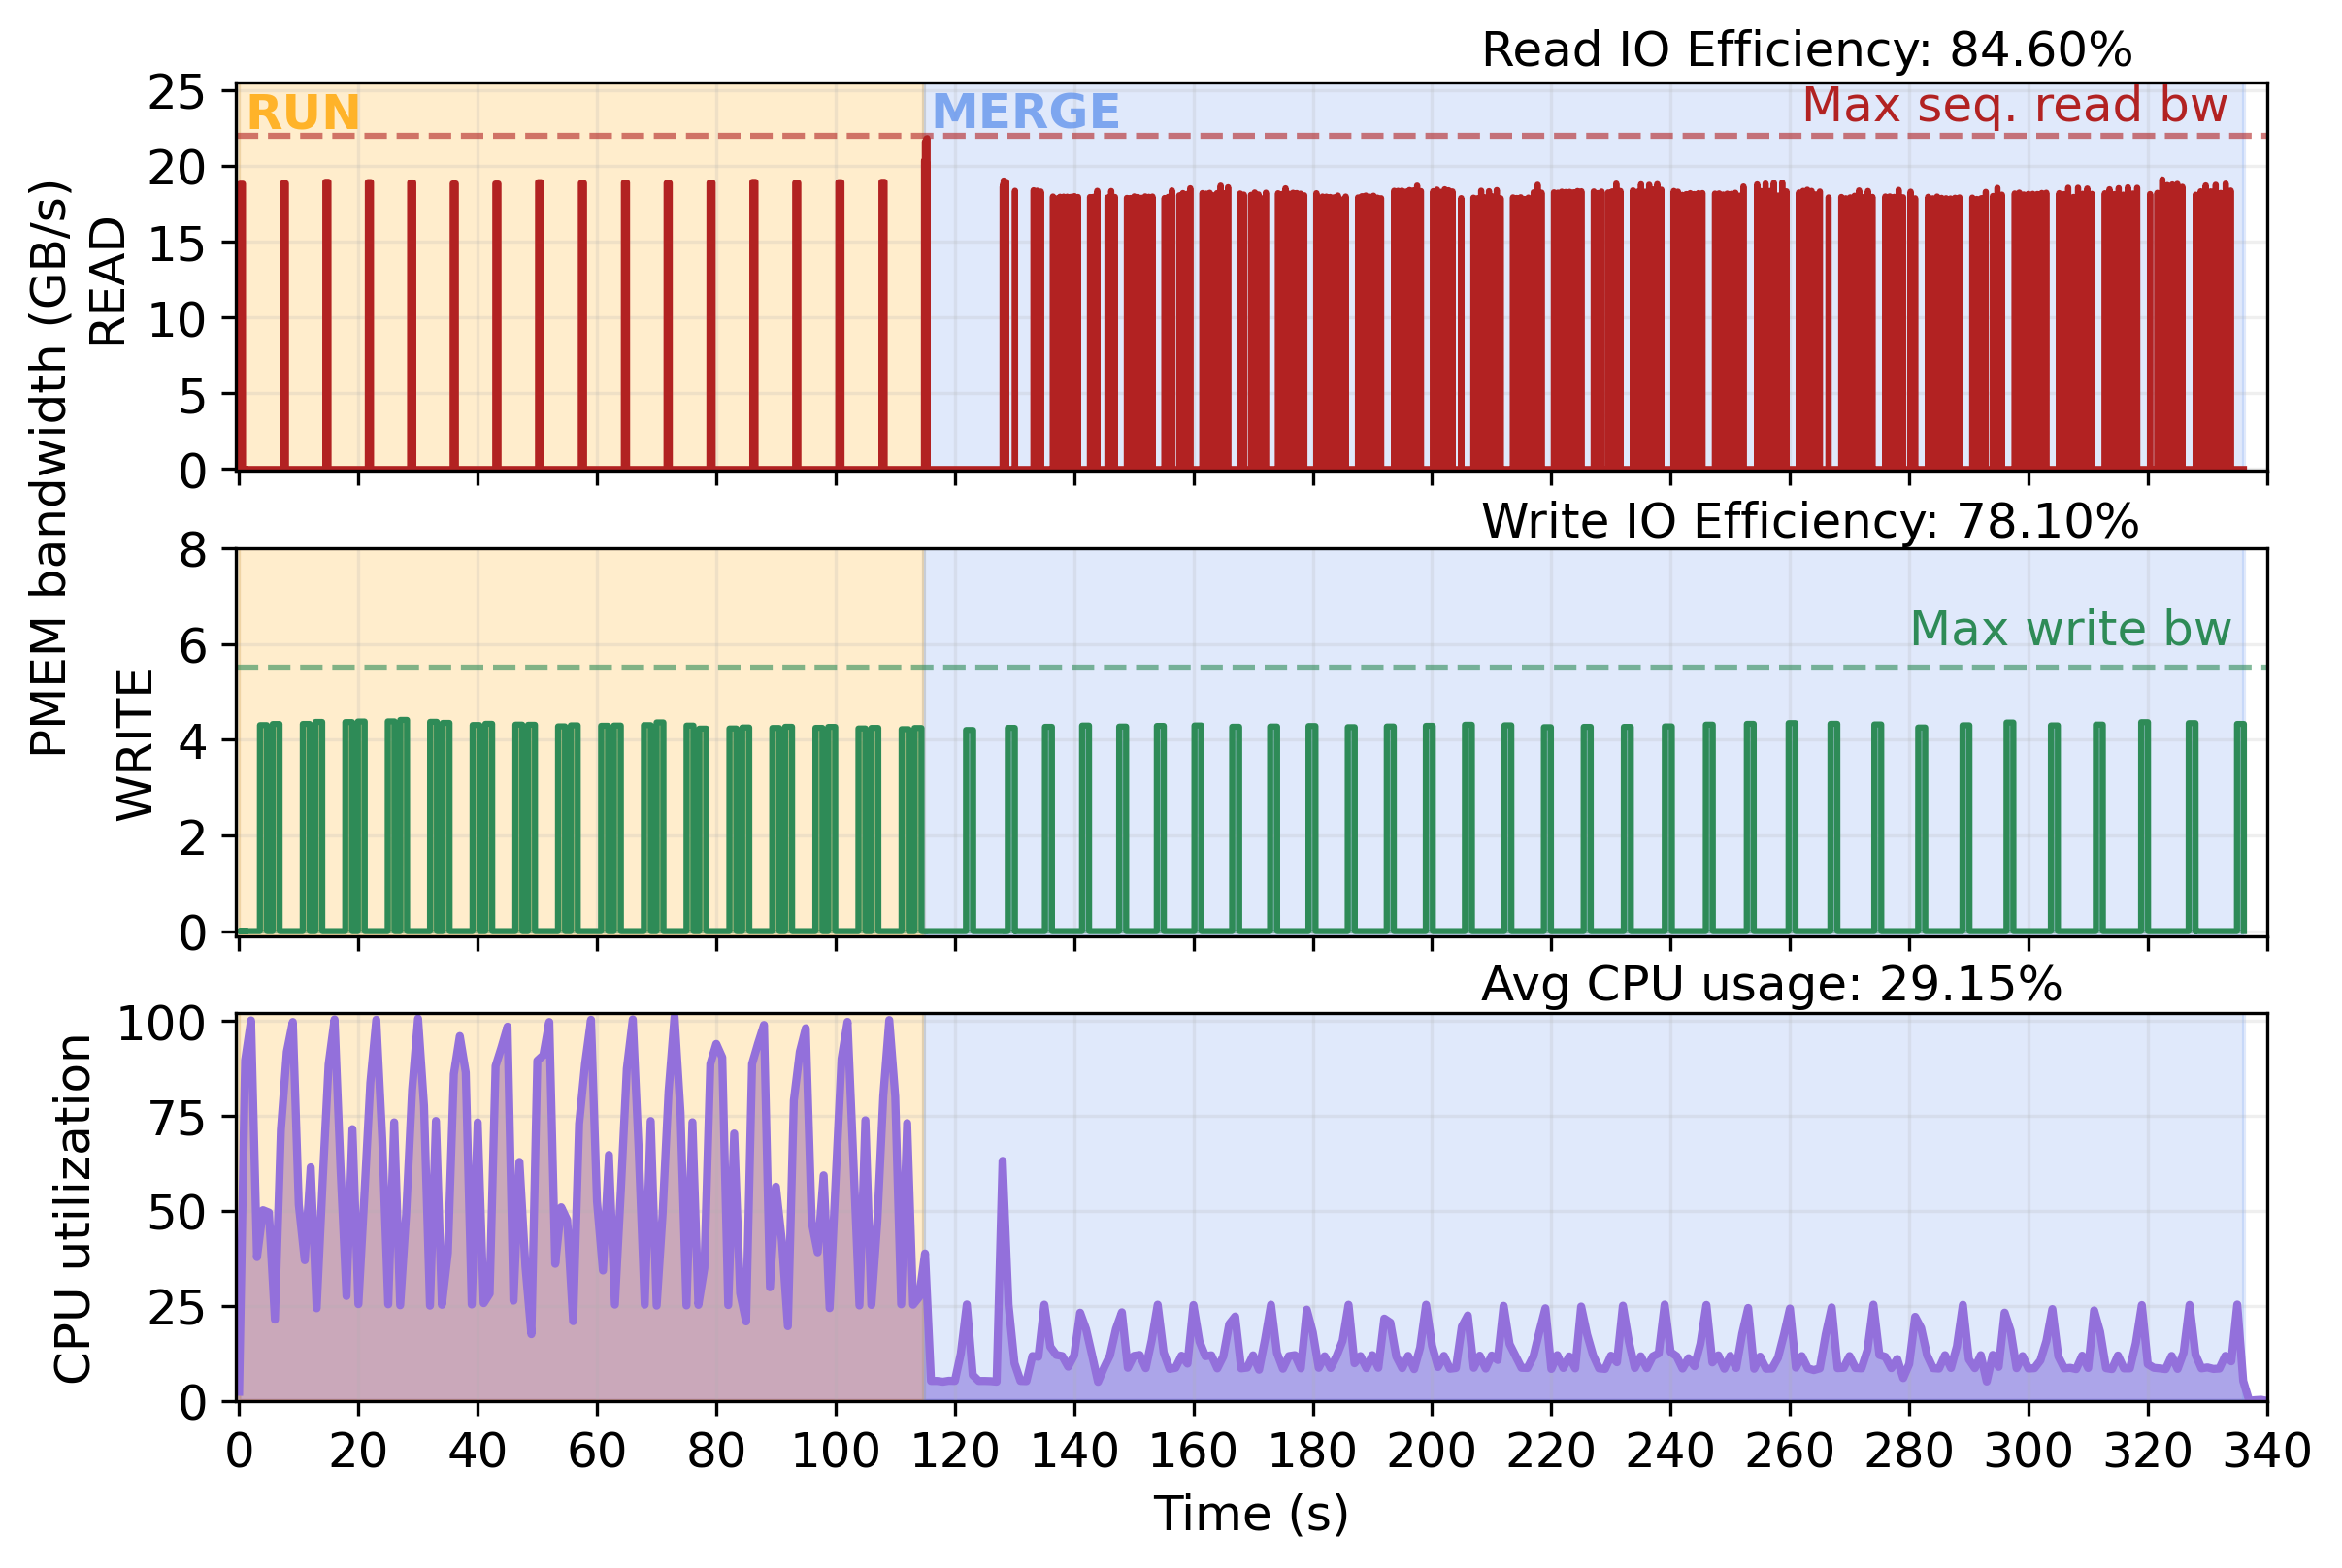

<Figure size 2700x1800 with 0 Axes>

<Figure size 2700x1800 with 0 Axes>

In [365]:
# cems_io_efficiency_subplots('10gb_ReadB-10gb_WriteB/40')
# cems_io_efficiency_subplots('1')
# cems_io_efficiency_subplots('paper/resources/ems_20RB_5WB_40Unsorted')
# cems_io_efficiency_subplots('paper/resources/ems_10RB_5WB_40Unsorted')
cems_io_efficiency_subplots('paper/10RB_5WB/160/CEMS')

In [ ]:
plt.rcParams.update({'font.size': 9})
def cems_sorts_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results", skipfooter = 9, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_tak en', 'data', 'read_bw', 'write_bw', 'sort_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0, 'sort_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    sort_time_pad = 0.5
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        sort_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        if row[1] == 'SORT':
            sort_bw = data_gb/row[2]
        if row[1] == 'SORT':            
            pm_df = pm_df.append({'time': row[0] - row[2] - 0.01 + sort_time_pad, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)    
            pm_df = pm_df.append({'time': row[0] - row[2] + sort_time_pad, 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + sort_time_pad, 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + 0.01 + sort_time_pad, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)
        else:
            pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)    
            pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)
    # print(pm_df)
    plt.figure()
    ax[0].set_xticks(np.arange(0, 100, step=2))
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].set_xlim(-0.5, 68)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='red', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='r', linestyle='--')
    ax[0].annotate('Max read bw', (60, 23), color='r')
    
    # Sorts per second
    ax[1].set_yticks(np.arange(0, 5.5, step=.5))
    ax[1].set_ylim(-0.1, 3)
    ax[1].plot(pm_df['time'], pm_df['sort_bw'], color='goldenrod', label="sort bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['sort_bw']], color='goldenrod', alpha=.6)
    
    ax[2].set_yticks(np.arange(0, 30.5, step=2))
    ax[2].set_ylim(-0.1, 9)
    ax[2].plot(pm_df['time'], pm_df['write_bw'], color='limegreen', label="write bw")
    ax[2].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='limegreen', alpha=.6)
    # Max write bandwidth
    ax[2].axhline(y=6.6, color='limegreen', linestyle='--')
    ax[2].annotate('Max write bw', (60, 7.4),  color='limegreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1, 'cems')
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 23), color="orange")
            ax[i].annotate('MERGE', ( 1 + run_time, 23), color="cornflowerblue")    
    
      
    ax[0].set_ylabel("READ", fontsize=6)
    ax[1].set_ylabel("SORT", fontsize=6)
    ax[2].set_ylabel("WRITE", fontsize=6)
    ax[2].set_xlabel("Time (s)")
    # plt.title(exp)
    
    ideal_read_time = (40*2)/22 # reading 40gb file twice at 22 GB/s speed
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (40*2)/6.4 # writing 40gb file twice at 6.6 GB/s speed
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.70, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    compute = (run_time + merge_time - (total_read_time + total_write_time)) / (run_time + merge_time)
    io = (total_read_time + total_write_time) / (run_time + merge_time)
    fig.text(0.67, 0.62, f"Total compute: {(compute * 100):.2f}%, Total IO: {(io*100):.2f}%")
    fig.text(0.70, 0.355, f"Write IO Efficiency: {write_eff:.2f}%")
    fig.text(0.070, 0.52, "Bandwidth (GB/s)", va='center', rotation='vertical')

    
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

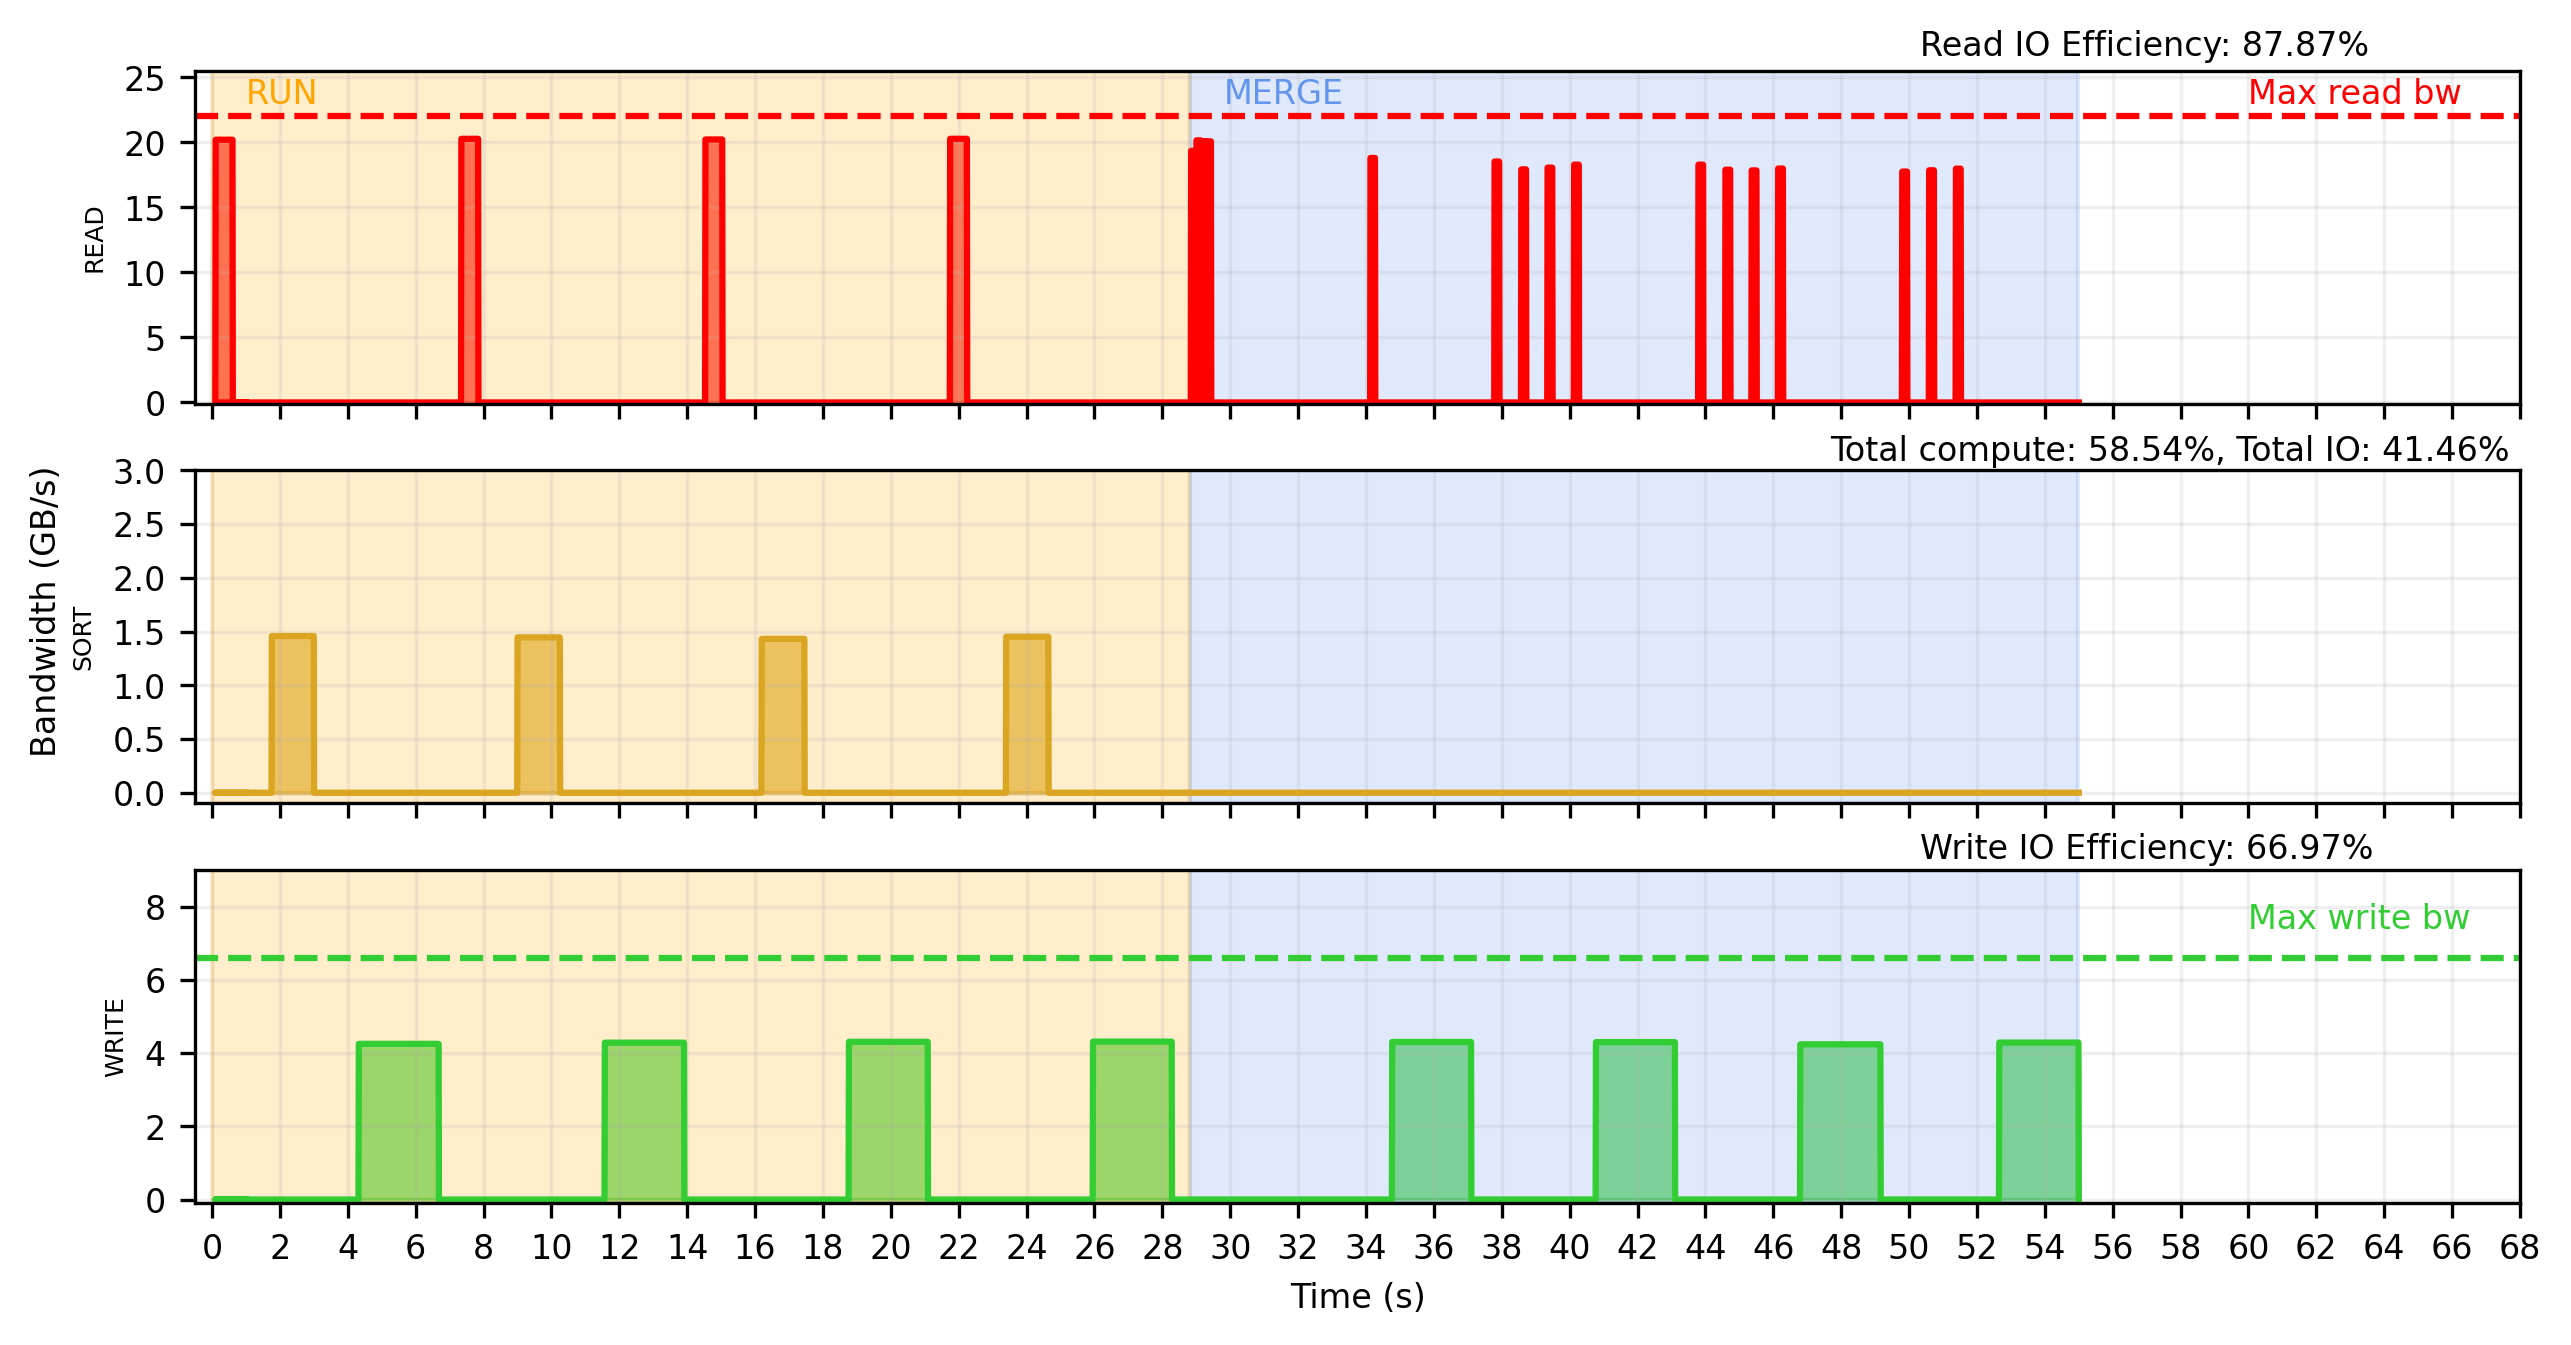

<Figure size 3000x1500 with 0 Axes>

In [789]:
cems_sorts_subplots('10gb_ReadB-10gb_WriteB/40')


## Wisc OnePass IO efficiency

In [351]:
plt.rcParams.update({'font.size': 12})
def wiscop_io_efficiency_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results", skipfooter = 6, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    # print(pm_df)
    plt.figure()
    ax[0].set_xticks(np.arange(0, 100, step=5))
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].set_xlim(-0.5, 27)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='firebrick', label="read bw")
    # print(pm_df['read_bw'])
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='firebrick', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='firebrick', linestyle='--', alpha=0.6)
    ax[0].annotate('Max seq. read bw', (20, 23), color='firebrick')
    ax[0].axhline(y=8, color='firebrick', linestyle='--', alpha=0.6)
    ax[0].annotate('MRRB(100)', (3, 9), color='firebrick')
    ax[0].axhline(y=4.4, color='firebrick', linestyle='--', alpha=0.6)
    ax[0].annotate('MRRB(10)', (3, 5), color='firebrick')
    
    ax[1].set_yticks(np.arange(0, 30.5, step=2))
    ax[1].set_ylim(-0.1, 8)
    ax[1].plot(pm_df['time'], pm_df['write_bw'], color='seagreen', label="write bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='seagreen', alpha=.6)
    # Max write bandwidth
    ax[1].axhline(y=5.5, color='seagreen', linestyle='--', alpha=0.6)
    ax[1].annotate('Max write bw', (20, 6),  color='seagreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1, 'onepass')
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['RECORD read'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 23), color="orange", weight='bold',alpha=0.8)
            # ax[i].annotate('MERGE', ( 1 + run_time, 23), color="cornflowerblue")    
        
    # CPU utilization
    ax[2].set_yticks(np.arange(0, 105, step=25))
    ax[2].set_ylim(-0.1, 105)
    cpu_pd = pd.read_csv("stats/"+ f"{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
    first_time = cpu_pd['epoch'][0] + 0 # 10 second sleep
    cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
     # because only using 20 cores, normalize values
    cpu_pd['usr'] = cpu_pd['usr'].map(lambda x: (x/62.5) * 100)
    cpu_pd['sys'] = cpu_pd['sys'].map(lambda x: (x/62.5) * 100)
    cpu_pd['total'] = cpu_pd.apply(lambda x: x['usr'] + x['sys'], axis=1)
    plt.figure()
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['jkusr'], lw=2, label = "usr")
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['sys'], lw=2, label = "sys")
    ax[2].plot(cpu_pd['epoch'], cpu_pd['total'], lw=2, label = "total", color='mediumpurple')
    ax[2].fill_between(cpu_pd['epoch'], cpu_pd['total'], color="mediumpurple", alpha=.6)
    
      
    # ax[0].set_ylabel("READ", fontsize=12)
    # ax[1].set_ylabel("WRITE", fontsize=12)
    # fig.text(0.046, 0.66, "PMEM bandwidth (GB/s)", va='center', rotation='vertical')
    # ax[2].set_ylabel("CPU utilization", fontsize=12)
    ax[2].set_xlabel("Time (s)")
    # plt.title(exp)
    
    ideal_read_time = (40 + 4)/22 
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (40)/5.5
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.60, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    fig.text(0.60, 0.62, f"Write IO Efficiency: {write_eff:.2f}%")
    #total_cpu_usage = cpu_pd['total'].sum()
    total_cpu_usage = 0
    cpu_epoch_counter = 0
    for index, row in cpu_pd.iterrows():
        if row['idl'] < 99:
            cpu_epoch_counter += 1
            total_cpu_usage += row['total']
    fig.text(0.60, 0.355, f"Avg CPU usage: {(total_cpu_usage/cpu_epoch_counter):.2f}%")
    fig.savefig('onepass-5wb-40gUnsorted.pdf', bbox_inches="tight")
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

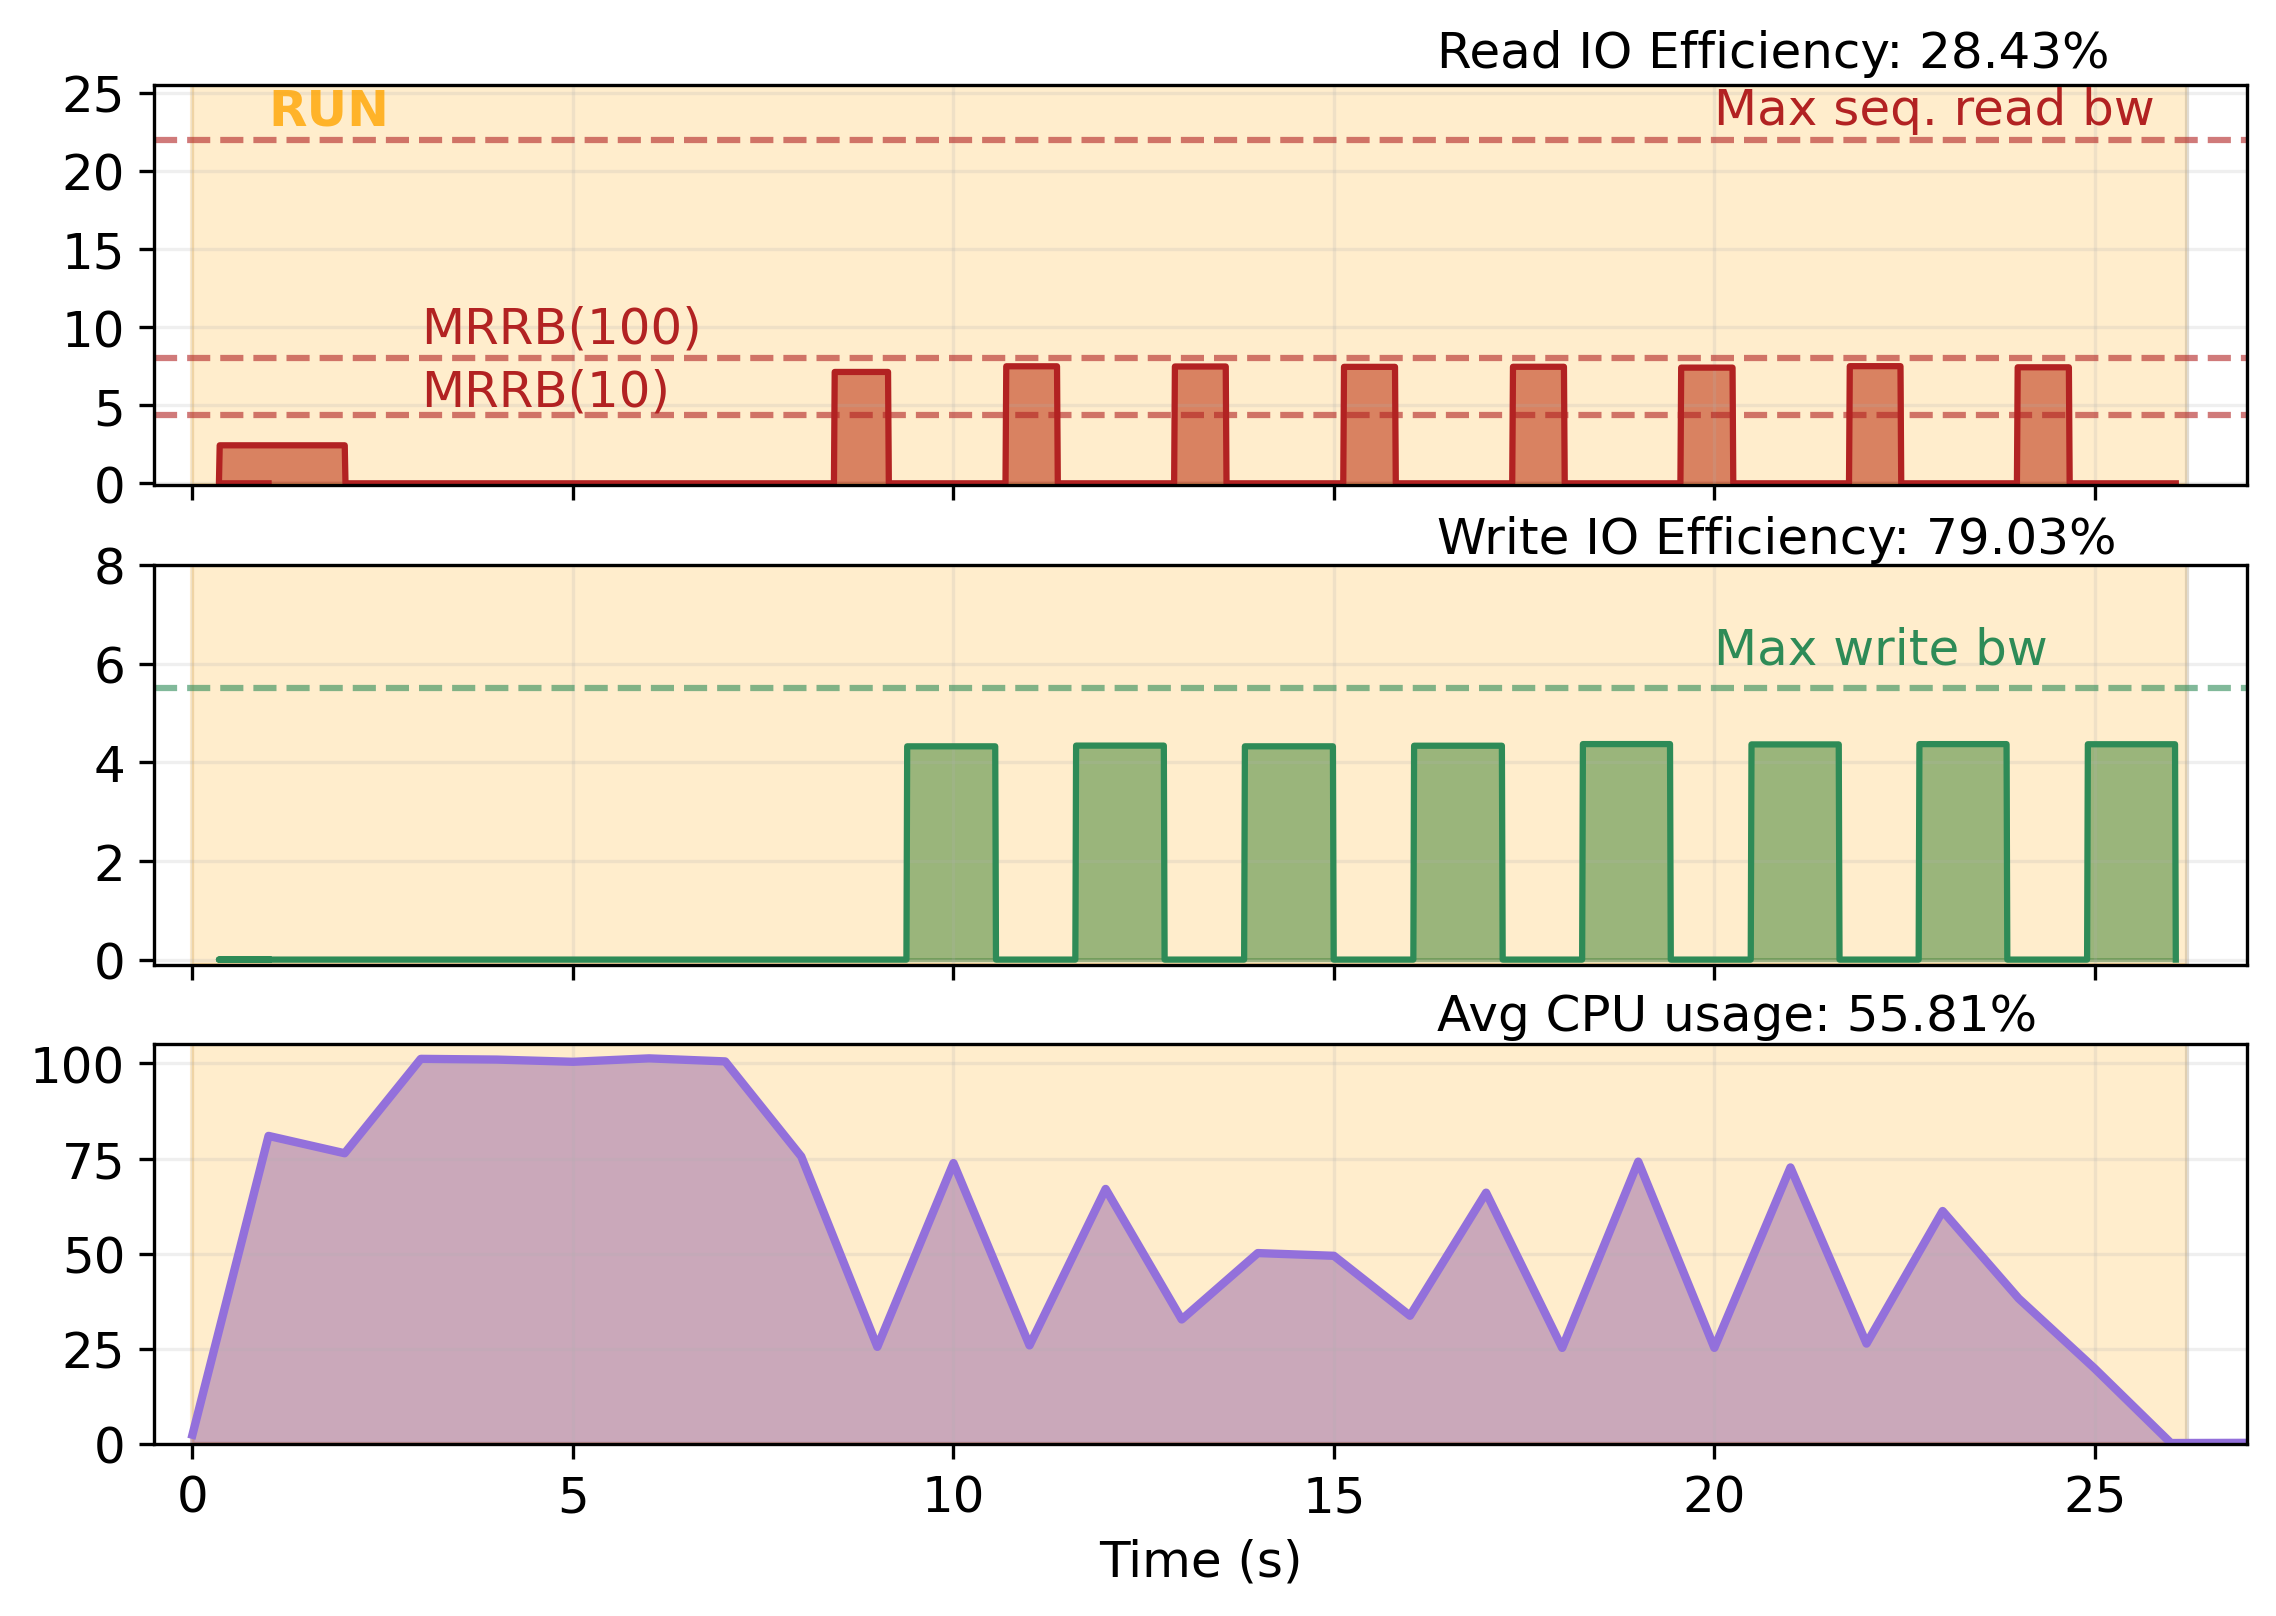

<Figure size 2700x1800 with 0 Axes>

<Figure size 2700x1800 with 0 Axes>

In [352]:
# wiscop_io_efficiency_subplots('20gb_WriteB/40')
# wiscop_io_efficiency_subplots('paper/resources/OnePass_10WB_40Unsorted')
wiscop_io_efficiency_subplots('paper/resources/OnePass_5WB_40Unsorted')
# wiscop_io_efficiency_subplots('1')

In [27]:
plt.rcParams.update({'font.size': 9})
def wiscop_sorts_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results", skipfooter = 5, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_tak en', 'data', 'read_bw', 'write_bw', 'sort_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0, 'sort_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    sort_time_pad = 0.5
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        sort_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        if row[1] == 'SORT':
            sort_bw = data_gb/row[2]
        # if row[1] == 'SORT':            
        #     pm_df = pm_df.append({'time': row[0] - row[2] - 0.01 + sort_time_pad, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)    
        #     pm_df = pm_df.append({'time': row[0] - row[2] + sort_time_pad, 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
        #     pm_df = pm_df.append({'time': row[0] + sort_time_pad, 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
        #     pm_df = pm_df.append({'time': row[0] + 0.01 + sort_time_pad, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)
        # else:
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)    
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)
    # print(pm_df)
    plt.figure()
    ax[0].set_xticks(np.arange(0, 100, step=2))
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].set_xlim(-0.5, 68)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='red', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='r', linestyle='--')
    ax[0].annotate('Max read bw', (60, 23), color='r')
    
    # Sorts per second
    ax[1].set_yticks(np.arange(0, 5.5, step=.5))
    ax[1].set_ylim(-0.1, 3)
    ax[1].plot(pm_df['time'], pm_df['sort_bw'], color='goldenrod', label="sort bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['sort_bw']], color='goldenrod', alpha=.6)
    
    ax[2].set_yticks(np.arange(0, 30.5, step=2))
    ax[2].set_ylim(-0.1, 9)
    ax[2].plot(pm_df['time'], pm_df['write_bw'], color='limegreen', label="write bw")
    ax[2].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='limegreen', alpha=.6)
    # Max write bandwidth
    ax[2].axhline(y=6.6, color='limegreen', linestyle='--')
    ax[2].annotate('Max write bw', (60, 7.4),  color='limegreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1)
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 23), color="orange")
            # ax[i].annotate('MERGE', ( 1 + run_time, 23), color="cornflowerblue")    
    
      
    ax[0].set_ylabel("READ", fontsize=6)
    ax[1].set_ylabel("SORT", fontsize=6)
    ax[2].set_ylabel("WRITE", fontsize=6)
    ax[2].set_xlabel("Time (s)")
    # plt.title(exp)
    
    ideal_read_time = (40+4)/22 # reading 40gb file twice at 22 GB/s speed
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (40+4)/6.4 # writing 40gb file twice at 6.6 GB/s speed
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.70, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    compute = (run_time + merge_time - (total_read_time + total_write_time)) / (run_time + merge_time)
    io = (total_read_time + total_write_time) / (run_time + merge_time)
    fig.text(0.67, 0.62, f"Total compute: {(compute * 100):.2f}%, Total IO: {(io*100):.2f}%")
    fig.text(0.70, 0.355, f"Write IO Efficiency: {write_eff:.2f}%")
    fig.text(0.070, 0.52, "Bandwidth (GB/s)", va='center', rotation='vertical')

    
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

TypeError: run_stats() missing 1 required positional argument: 'mode'

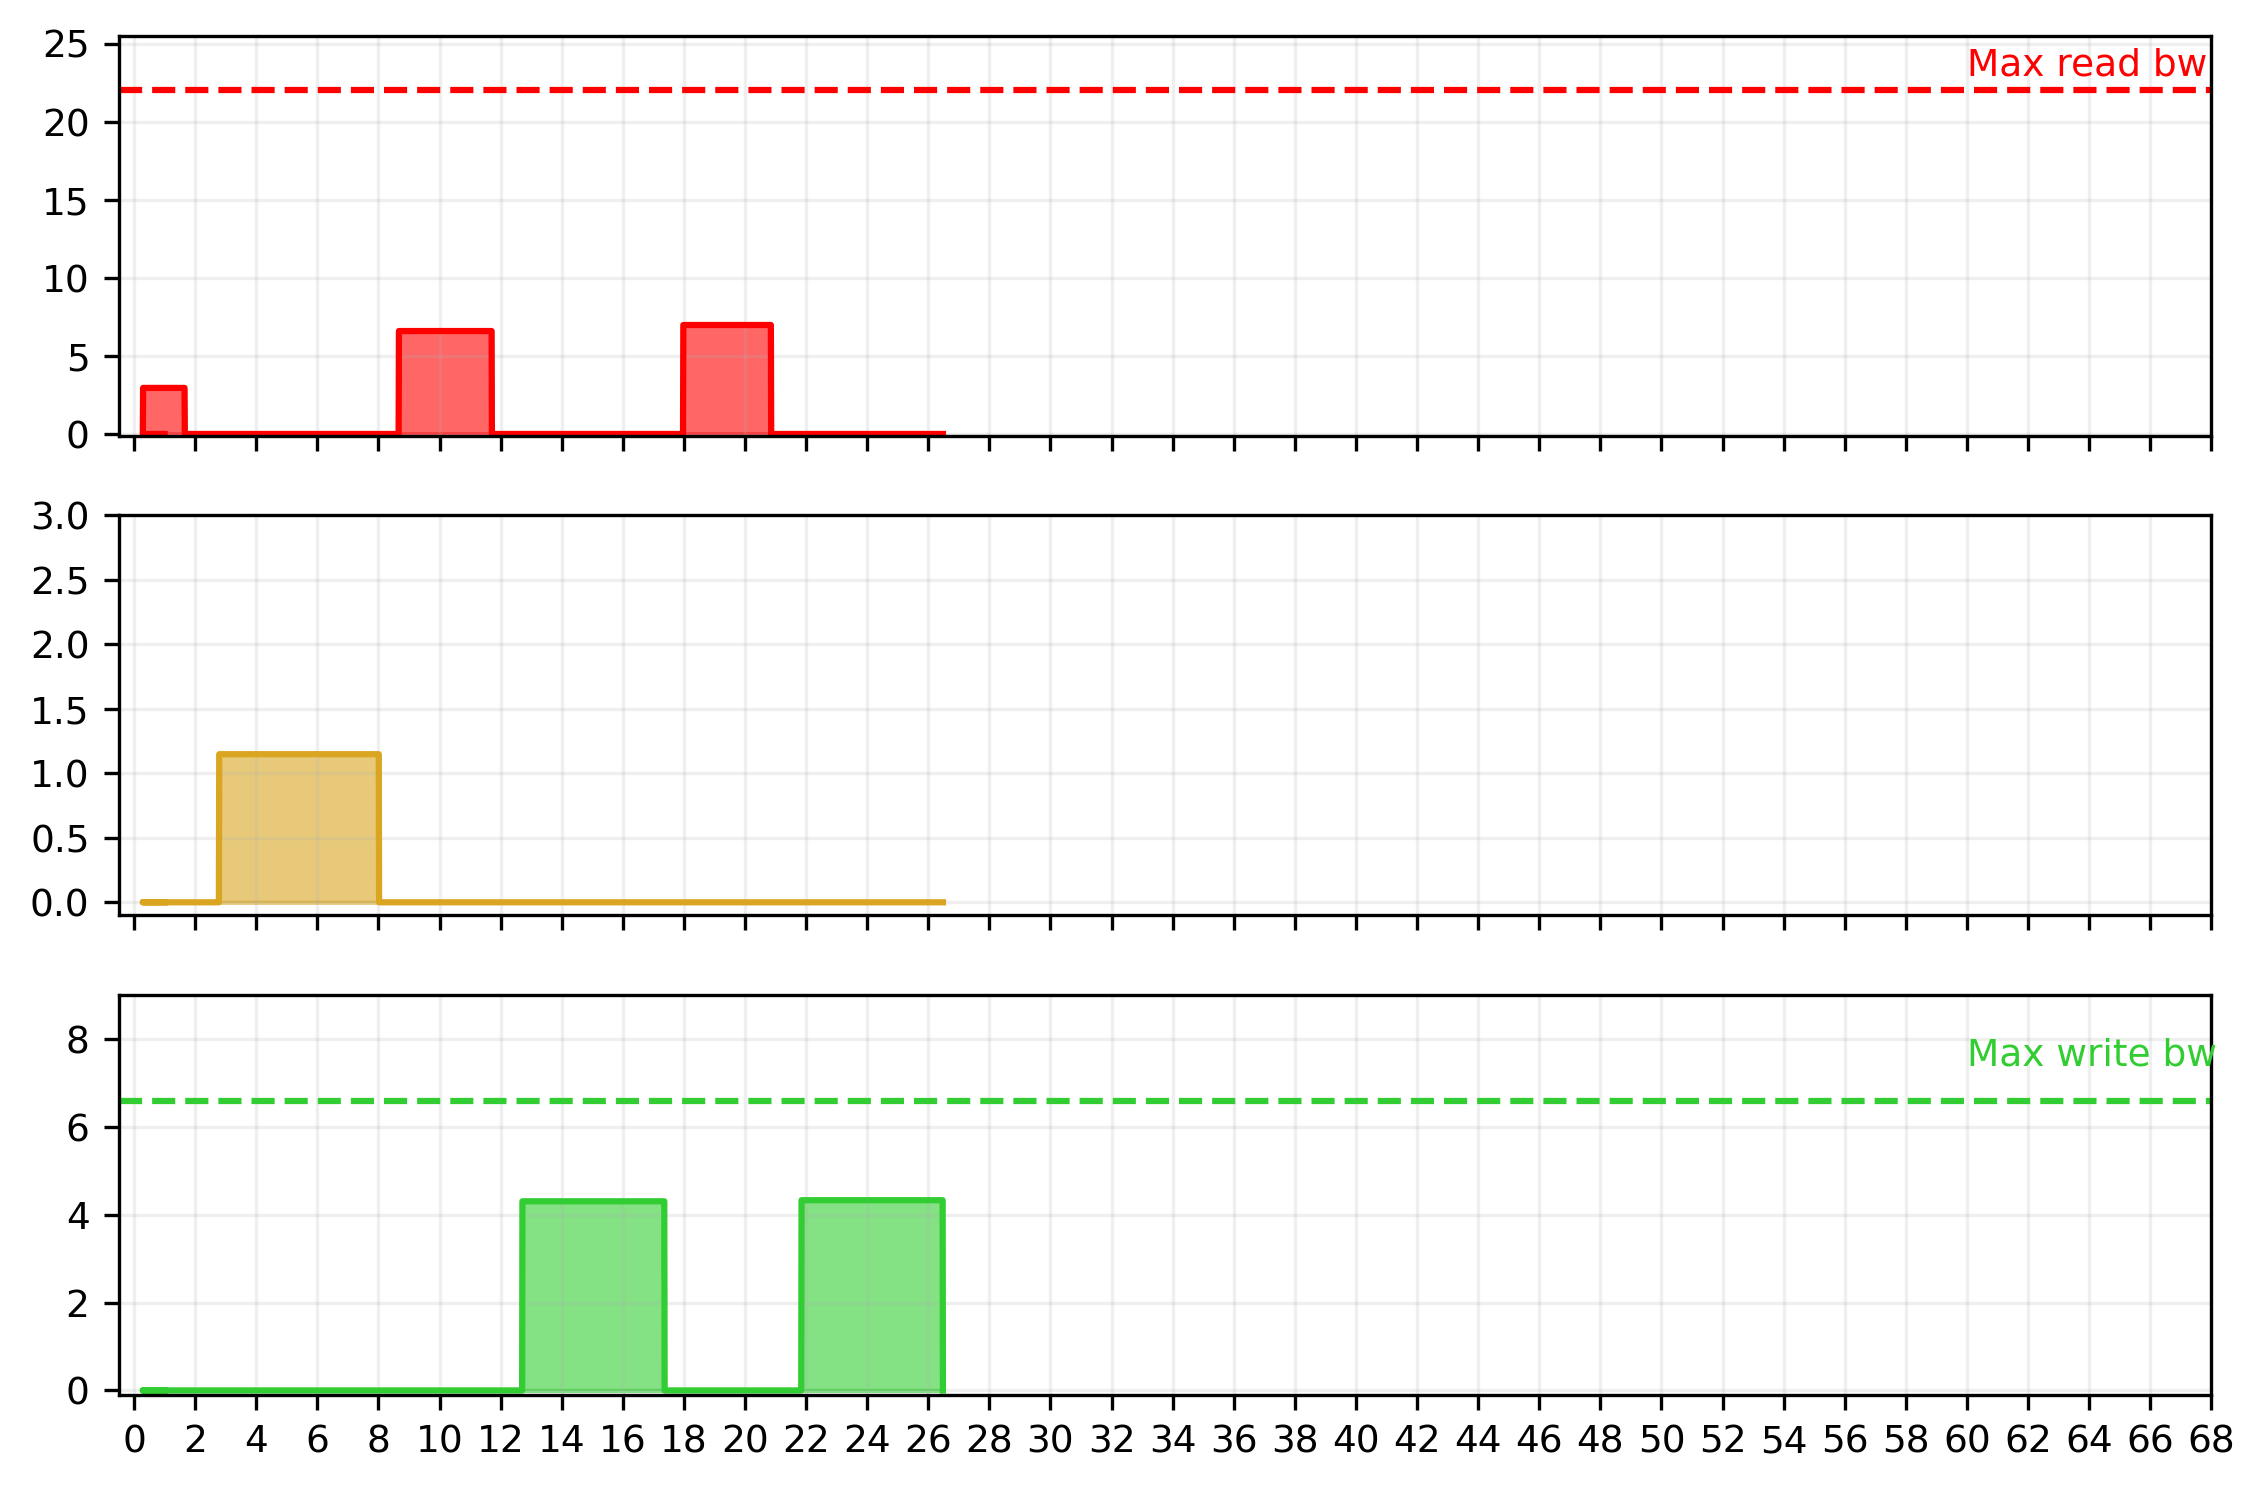

<Figure size 2700x1800 with 0 Axes>

In [28]:
wiscop_sorts_subplots('20gb_WriteB/40')

## WiscM IO efficiency

In [346]:
plt.rcParams.update({'font.size': 12})
def wiscm_io_efficiency_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results_bkp", skipfooter = 10, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 
                              'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 
                              'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    # print(pm_df)    
    plt.figure()
    ax[0].set_xticks(np.arange(0, 170, step=10))
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].set_xlim(-0.5, 165)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='firebrick', label="read bw")
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='firebrick', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='firebrick', linestyle='--', alpha=0.6)
    ax[0].annotate('Max seq. read bw', (123, 23), color='firebrick')

    ax[0].axhline(y=8.8, color='firebrick', linestyle='--', alpha=0.6)
    ax[0].annotate('MRRB(100 B)', (5, 10), color='firebrick')
    
    ax[0].axhline(y=3.8, color='firebrick', linestyle='--', alpha=0.6)
    ax[0].annotate('MRRB(10 B)', (5, 4.4), color='firebrick')
    
    ax[1].set_yticks(np.arange(0, 30.5, step=2))
    ax[1].set_ylim(-0.1, 8)
    ax[1].plot(pm_df['time'], pm_df['write_bw'], color='seagreen', label="write bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='seagreen', alpha=.6)
    # Max write bandwidth
    ax[1].axhline(y=5.5, color='seagreen', linestyle='--')
    ax[1].annotate('Max write bw', (123, 6),  color='seagreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1, 'mergepass')
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE'] +  data['RECORD read']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 23), color="orange", weight='bold',alpha=0.8)
            ax[i].annotate('MERGE', ( 1 + run_time, 23), color="cornflowerblue", weight='bold',alpha=0.8)    
        
    # CPU utilization
    ax[2].set_yticks(np.arange(0, 101, step=25))
    ax[2].set_ylim(-0.1, 102)
    cpu_pd = pd.read_csv("stats/"+ f"{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
    first_time = cpu_pd['epoch'][0] + 0 # 10 second sleep
    cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
    
     # because only using 20 cores, normalize values
    cpu_pd['usr'] = cpu_pd['usr'].map(lambda x: (x/62.5) * 100)
    cpu_pd['sys'] = cpu_pd['sys'].map(lambda x: (x/62.5) * 100)
    cpu_pd['total'] = cpu_pd.apply(lambda x: x['usr'] + x['sys'], axis=1)
    plt.figure()
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['jkusr'], lw=2, label = "usr")
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['sys'], lw=2, label = "sys")
    ax[2].plot(cpu_pd['epoch'], cpu_pd['total'], lw=2, label = "total", color='mediumpurple')
    ax[2].fill_between(cpu_pd['epoch'], cpu_pd['total'], color="mediumpurple", alpha=.6)
    
      
    # ax[0].set_ylabel("READ", fontsize=12)
    # ax[1].set_ylabel("WRITE", fontsize=12)
    # fig.text(0.046, 0.66, "PMEM bandwidth (GB/s)", va='center', rotation='vertical')
    # ax[2].set_ylabel("CPU utilization", fontsize=12)
    ax[2].set_xlabel("Time (s)")
    # plt.title(exp)
    file_size = int(exp.split("/")[-2]) * 1e9
    indexMap_size = (file_size/100) * 15 ##### Remember to change this if KV changes!
    ideal_read_time = ((file_size/10)/1e9 + # keys only during RUN
                       indexMap_size/1e9 + # key + index during MERGE
                       file_size/1e9 # reading the file for records
                      )/22
    # mrrb_10_ideal = 
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (indexMap_size/1e9 + # the index file 
                        file_size/1e9 # the final output
                       )/5.5 # writing 40gb file twice at 5.5 GB/s speed
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.60, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    fig.text(0.60, 0.62, f"Write IO Efficiency: {write_eff:.2f}%")
    #total_cpu_usage = cpu_pd['total'].sum()
    total_cpu_usage = 0
    cpu_epoch_counter = 0
    for index, row in cpu_pd.iterrows():
        if row['idl'] < 99:
            cpu_epoch_counter += 1
            total_cpu_usage += row['total']
    fig.text(0.60, 0.355, f"Avg CPU usage: {(total_cpu_usage/cpu_epoch_counter):.2f}%")
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    fig.savefig('mergepass-5wb-160gUnsorted.pdf', bbox_inches="tight")

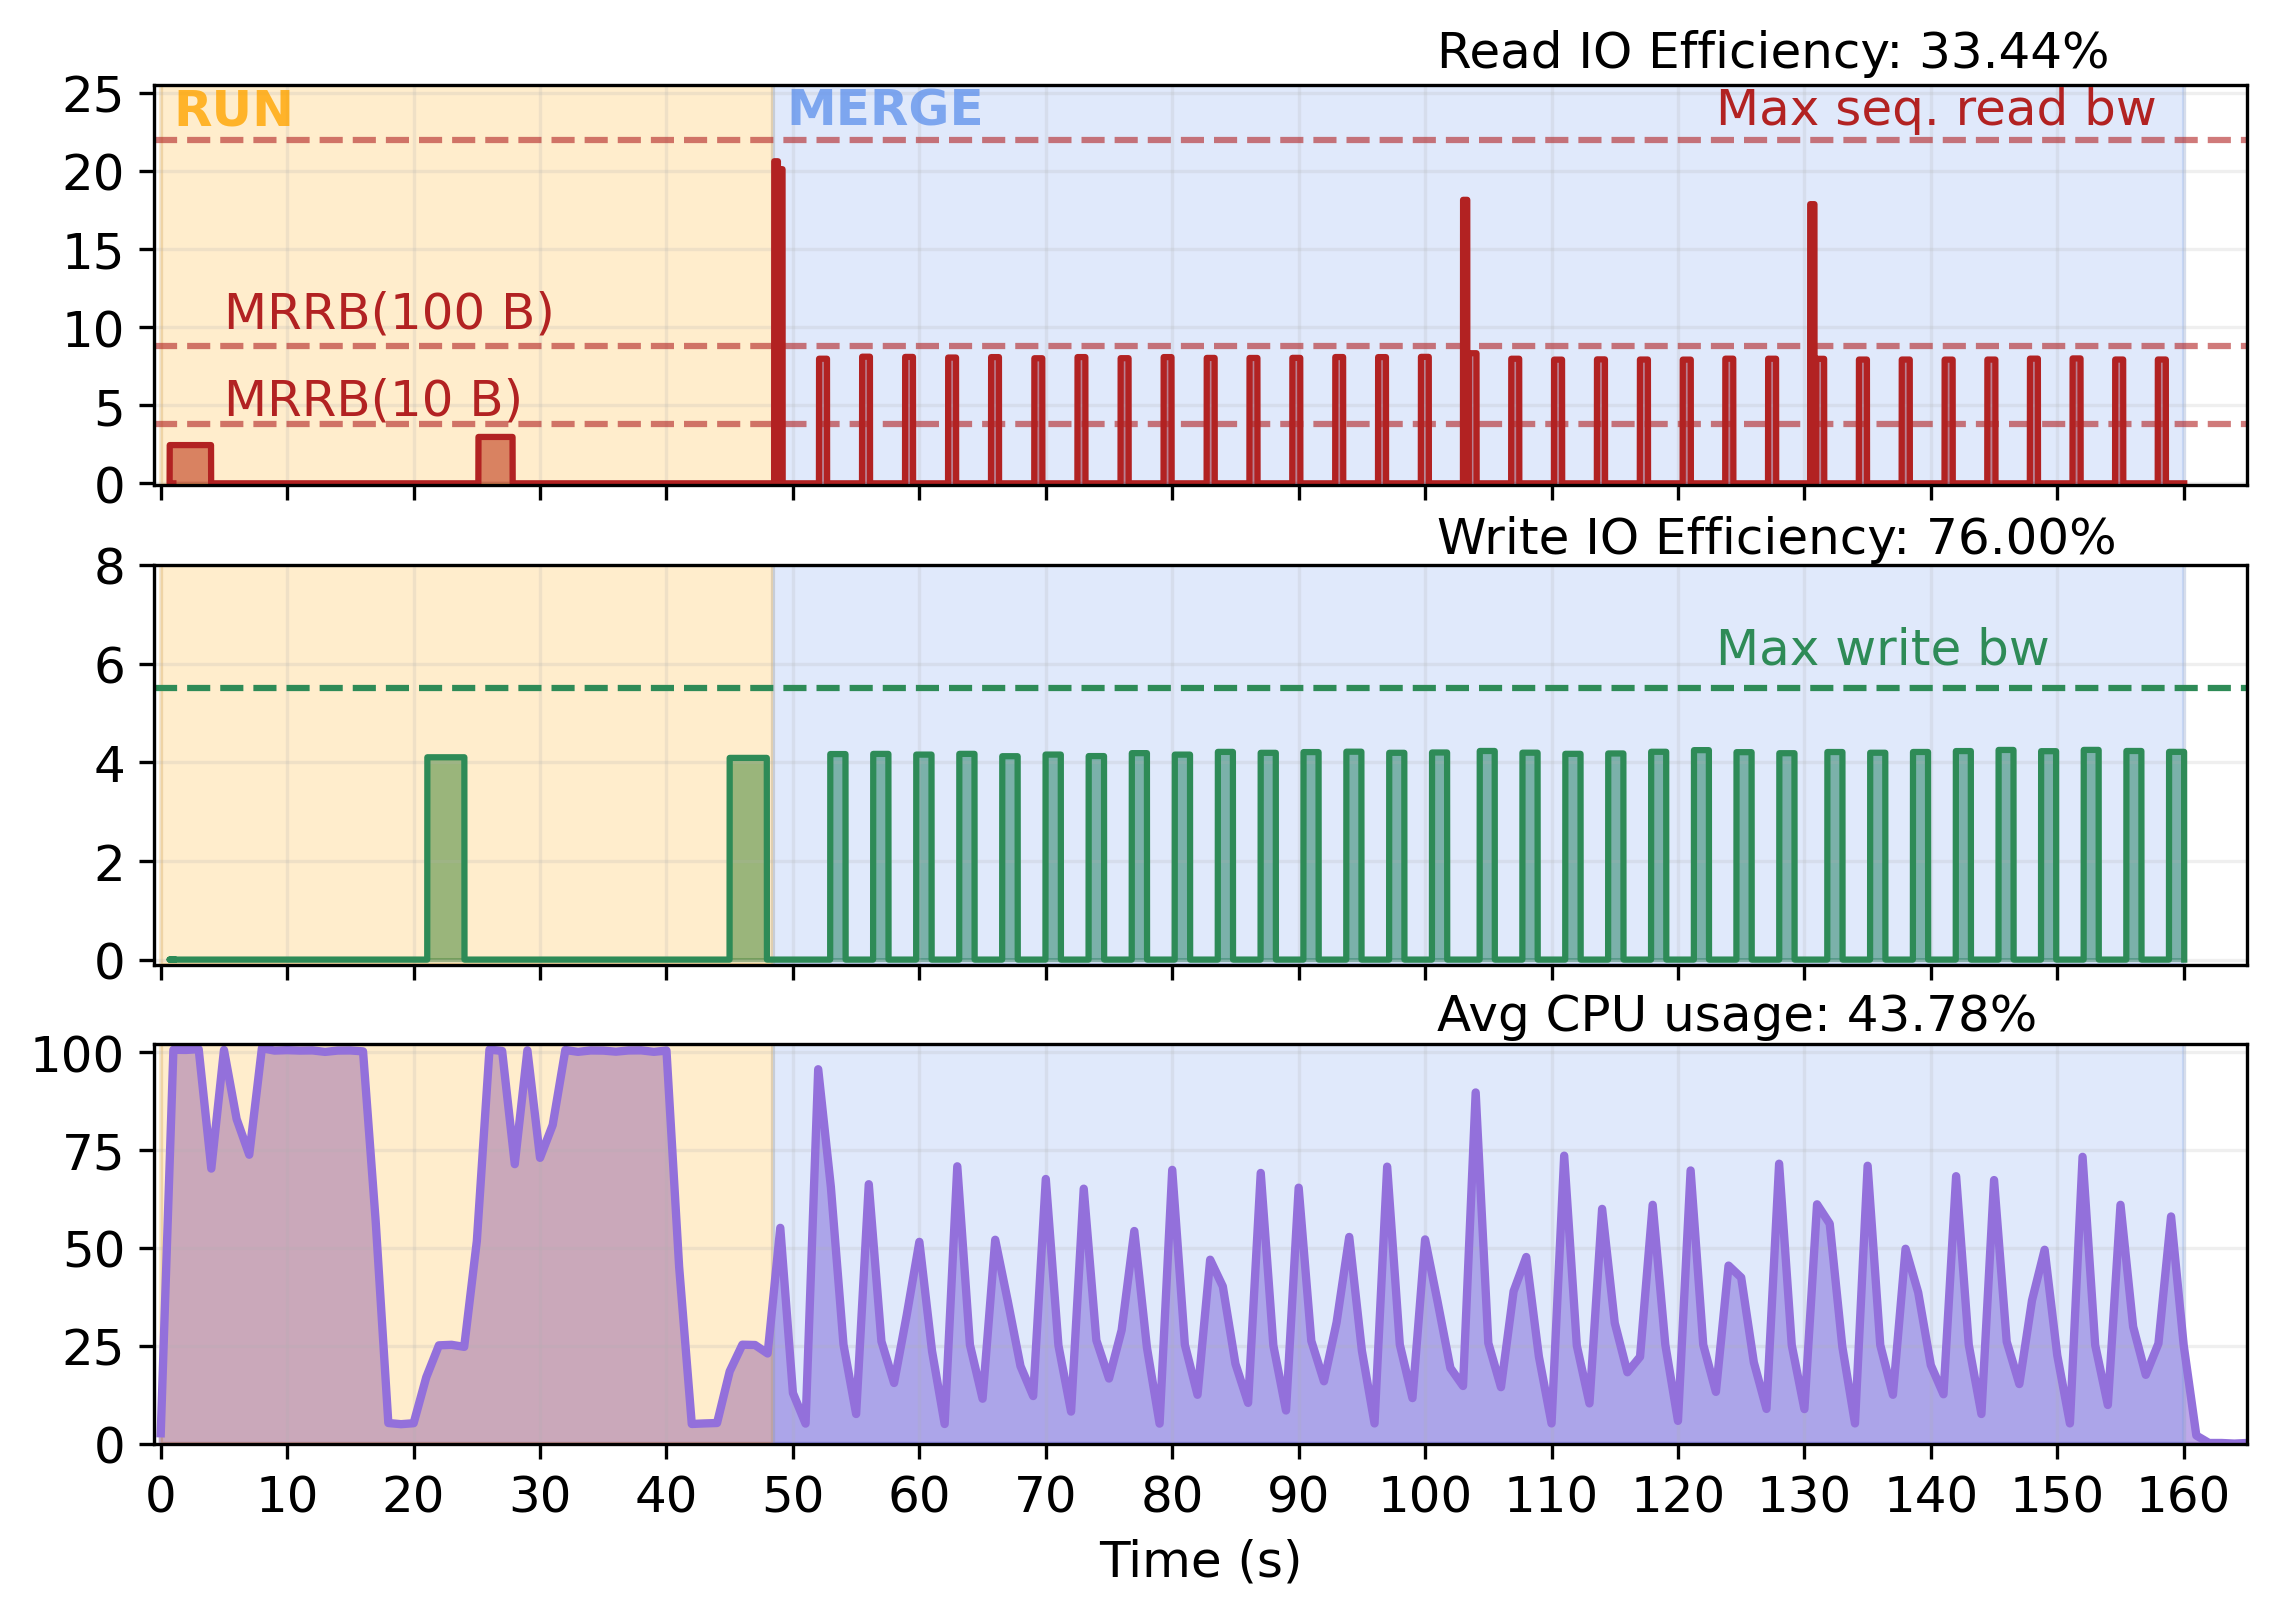

<Figure size 2700x1800 with 0 Axes>

<Figure size 2700x1800 with 0 Axes>

In [347]:
wiscm_io_efficiency_subplots('paper/10RB_5WB/160/WiscSort')
# TRY CHANGING results to rsults_bkp in run_stats
# wiscm_io_efficiency_subplots('paper/10RB_5WB/200/WiscSort')

In [212]:
plt.rcParams.update({'font.size': 8})
def wiscm_sorts_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results", skipfooter = 9, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_tak en', 'data', 'read_bw', 'write_bw', 'sort_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0, 'sort_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    sort_time_pad = 0.5
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        sort_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        if row[1] == 'SORT':
            sort_bw = data_gb/row[2]
        if row[1] == 'SORT':            
            pm_df = pm_df.append({'time': row[0] - row[2] - 0.01 + sort_time_pad, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)    
            pm_df = pm_df.append({'time': row[0] - row[2] + sort_time_pad, 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + sort_time_pad, 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + 0.01 + sort_time_pad, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)
        else:
            pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)    
            pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw, 'sort_bw': sort_bw}, ignore_index=True)
            pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0, 'sort_bw':0}, ignore_index=True)
    # print(pm_df)
    plt.figure()
    ax[0].set_xticks(np.arange(0, 100, step=2))
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].set_xlim(-0.5, 68)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='red', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='r', linestyle='--')
    ax[0].annotate('Max read bw', (60, 23), color='r')
    
    # Sorts per second
    ax[1].set_yticks(np.arange(0, 5.5, step=.5))
    ax[1].set_ylim(-0.1, 3)
    ax[1].plot(pm_df['time'], pm_df['sort_bw'], color='goldenrod', label="sort bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['sort_bw']], color='goldenrod', alpha=.6)
    
    ax[2].set_yticks(np.arange(0, 30.5, step=2))
    ax[2].set_ylim(-0.1, 9)
    ax[2].plot(pm_df['time'], pm_df['write_bw'], color='limegreen', label="write bw")
    ax[2].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='limegreen', alpha=.6)
    # Max write bandwidth
    ax[2].axhline(y=6.6, color='limegreen', linestyle='--')
    ax[2].annotate('Max write bw', (60, 7.4),  color='limegreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1)
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 23), color="orange")
            ax[i].annotate('MERGE', ( 1 + run_time, 23), color="cornflowerblue")    
    
      
    ax[0].set_ylabel("READ", fontsize=6)
    ax[1].set_ylabel("SORT", fontsize=6)
    ax[2].set_ylabel("WRITE", fontsize=6)
    ax[2].set_xlabel("Time (s)")
    # plt.title(exp)
    
    ideal_read_time = (4 + # keys only during RUN
                       6 + # key + index during MERGE
                       40 # reading the file
                      )/22 # reading 40gb file twice at 22 GB/s speed
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (6 + # the index file 
                        40 # the final output
                       )/6.4 # writing 40gb file twice at 6.6 GB/s speed
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.70, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    compute = (run_time + merge_time - (total_read_time + total_write_time)) / (run_time + merge_time)
    io = (total_read_time + total_write_time) / (run_time + merge_time)
    fig.text(0.67, 0.62, f"Total compute: {(compute * 100):.2f}%, Total IO: {(io*100):.2f}%")
    fig.text(0.70, 0.355, f"Write IO Efficiency: {write_eff:.2f}%")
    fig.text(0.070, 0.52, "Bandwidth (GB/s)", va='center', rotation='vertical')

    
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

TypeError: run_stats() missing 1 required positional argument: 'mode'

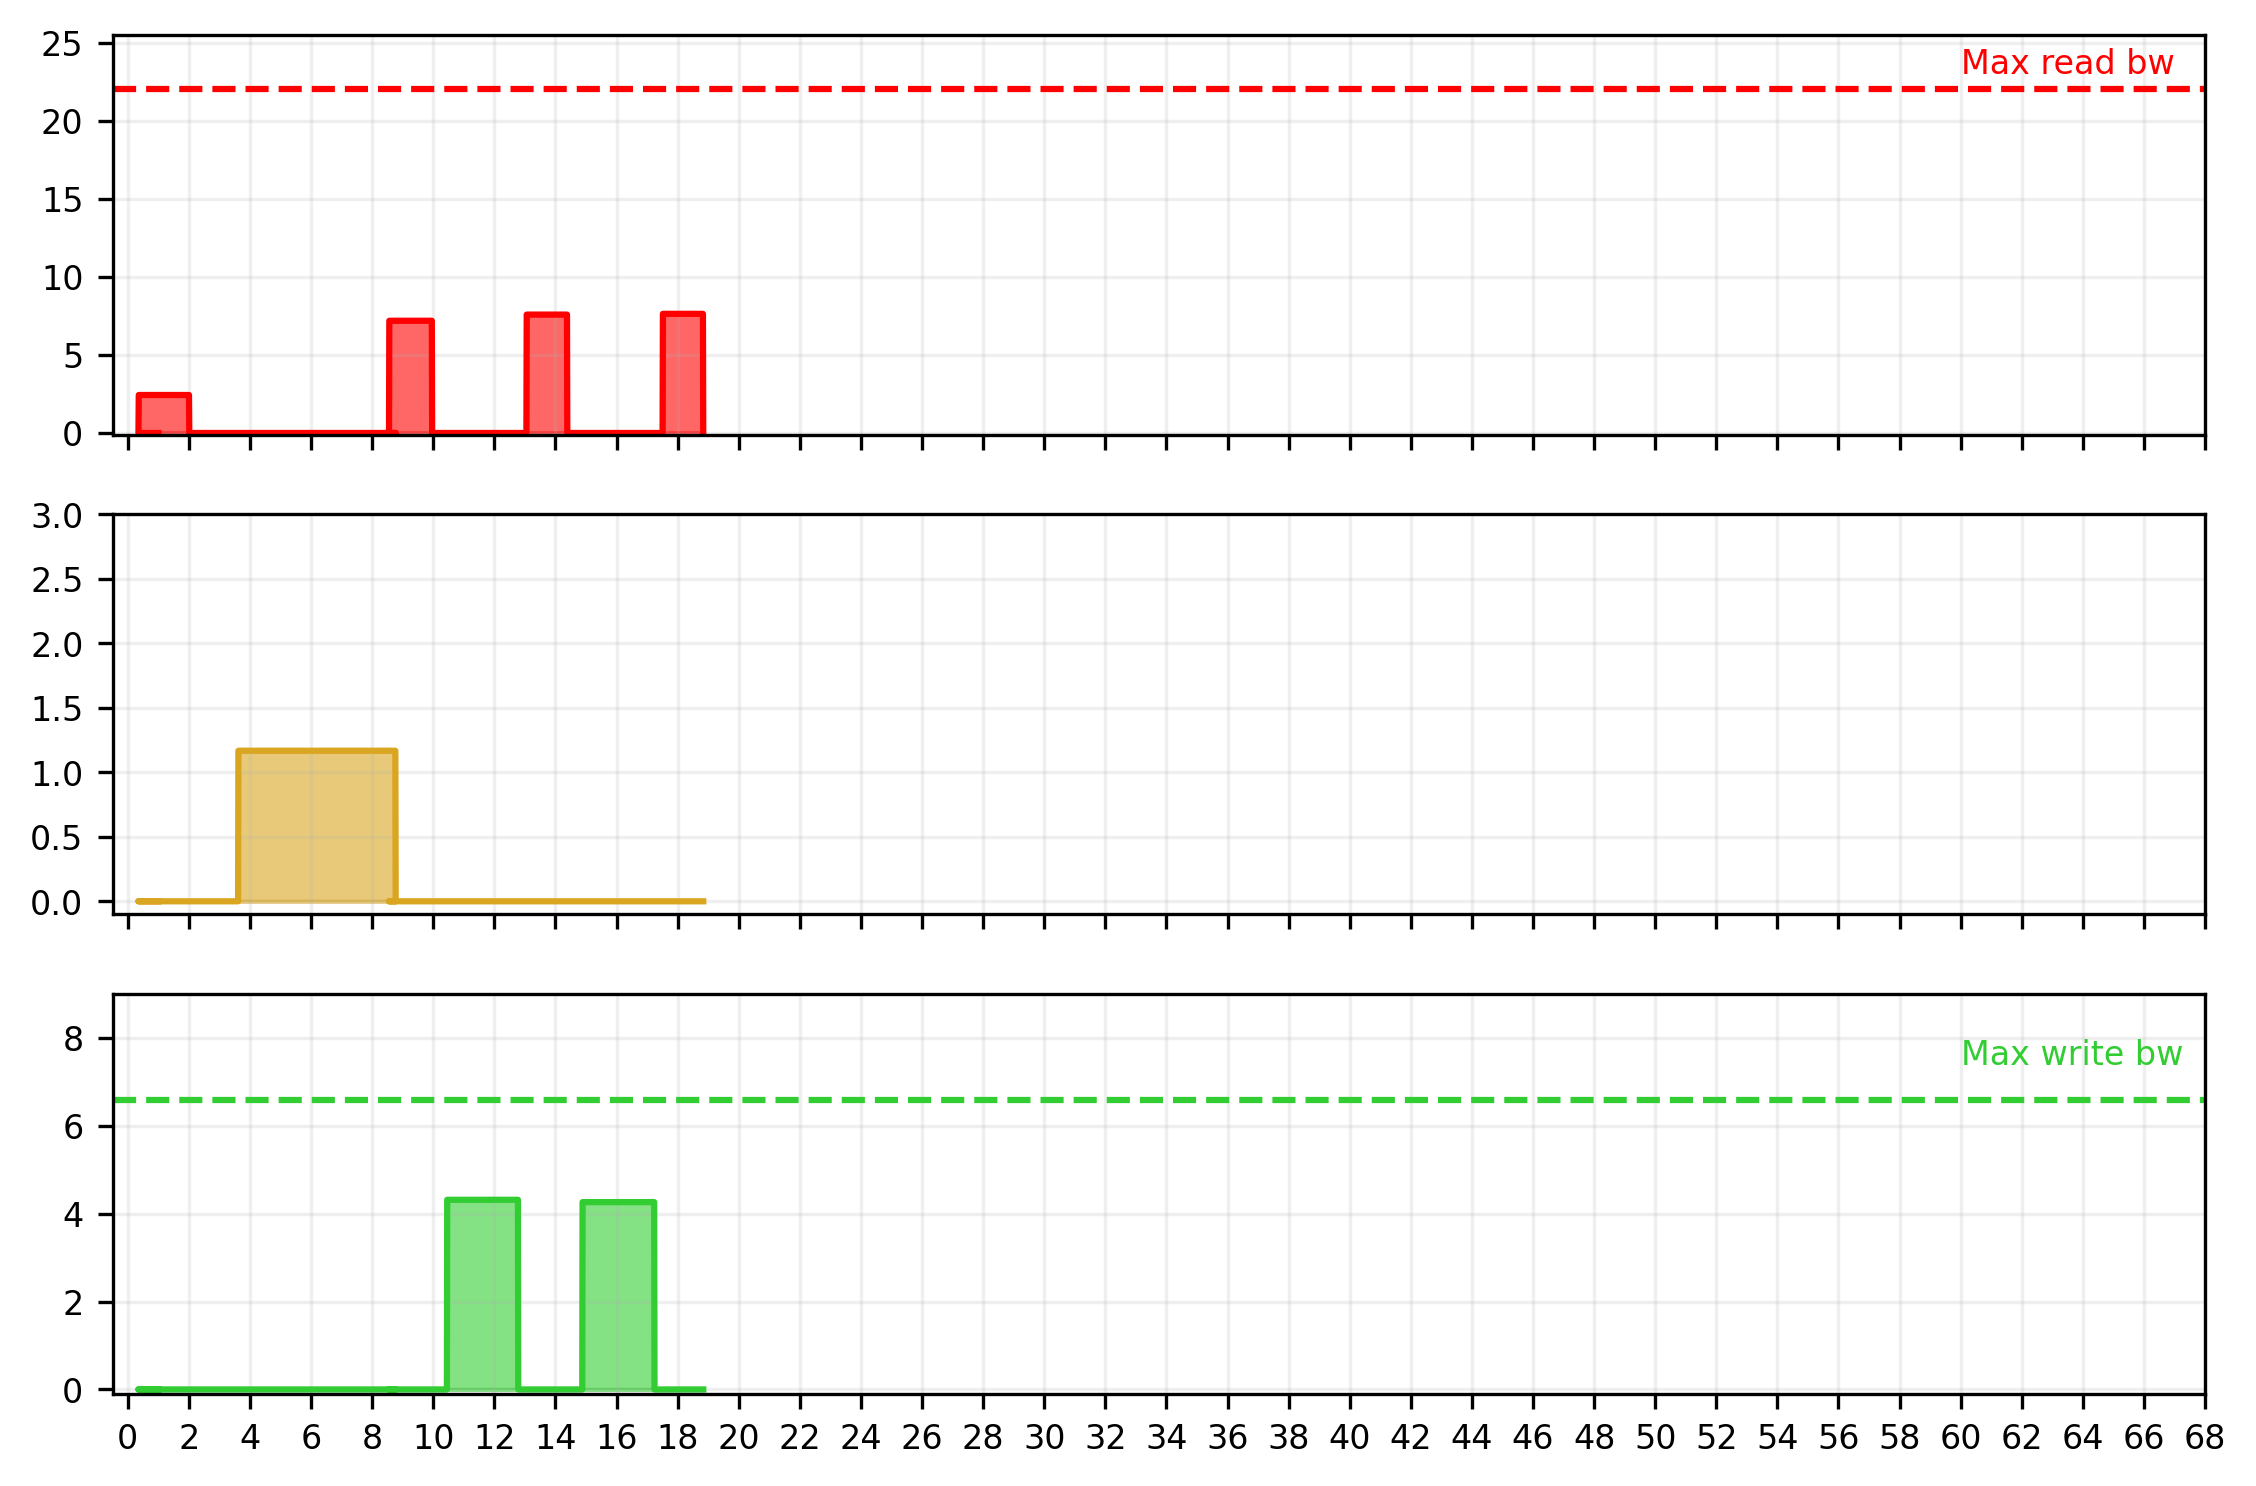

<Figure size 2700x1800 with 0 Axes>

In [213]:
# wiscm_sorts_subplots('20gb_WriteB/40/WiscM')
wiscm_sorts_subplots('paper/resources/OnePass_10WB_40Unsorted')

## Isolate wiscsort

In [72]:
plt.rcParams.update({'font.size': 10})
def wisci_io_efficiency_subplots(exp):
    fig,ax =  plt.subplots(3, 1, sharex=True)
    
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/results_bkp", skipfooter = 11, delimiter=r",", engine='python', header=None)
    pm_df = pd.DataFrame(columns = ['time', 'OP', 'time_taken', 'data', 'read_bw', 'write_bw'])
    pm_df = pm_df.append({'time': 1, 'OP': 'FILLER', 'time_taken': 0, 'data': 0, 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    total_read_time = 0
    total_write_time = 0
    for index, row in pmem_pd.iterrows():
        read_bw = 0
        write_bw = 0
        data_gb = row[3] * 1.0e-9
        if row[1] == 'READ':
            read_bw = data_gb/row[2]
            total_read_time += row[2]
        if row[1] == 'WRITE':
            write_bw = data_gb/row[2]
            total_write_time += row[2]
        pm_df = pm_df.append({'time': row[0] - row[2] - 0.01, 'OP': 'FILLER', 'time_taken': row[2], 
                              'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)    
        pm_df = pm_df.append({'time': row[0] - row[2], 'OP': row[1], 'time_taken': row[2], 
                              'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0], 'OP': row[1], 'time_taken': row[2], 'data': row[3], 'read_bw': read_bw, 'write_bw': write_bw}, ignore_index=True)
        pm_df = pm_df.append({'time': row[0] + 0.01, 'OP': 'FILLER', 'time_taken': row[2], 'data': row[3], 'read_bw': 0, 'write_bw': 0}, ignore_index=True)
    print(pm_df)    
    plt.figure()
    ax[0].set_xticks(np.arange(0, 170, step=10))
    ax[0].set_yticks(np.arange(0, 30.5, step=5))
    ax[0].set_ylim(-0.1, 25.5)
    ax[0].set_xlim(-0.5, 165)
    ax[0].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    ax[0].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['read_bw']], color='red', alpha=.6)
    # Max read bandwidth
    ax[0].axhline(y=22, color='black', linestyle='--', alpha=0.6)
    ax[0].annotate('Max seq. read bw', (133, 23), color='black')

    ax[0].axhline(y=8.8, color='black', linestyle='--', alpha=0.6)
    ax[0].annotate('MRRB(100 B)', (5, 10), color='black')
    
    ax[0].axhline(y=3.8, color='black', linestyle='--', alpha=0.6)
    ax[0].annotate('MRRB(10 B)', (5, 4.4), color='black')
    
    ax[1].set_yticks(np.arange(0, 30.5, step=5))
    ax[1].set_ylim(-0.1, 25.5)
    ax[1].plot(pm_df['time'], pm_df['write_bw'], color='limegreen', label="write bw")
    ax[1].fill_between([float(str(q)) for q in pm_df['time']], [float(str(q)) for q in pm_df['write_bw']], color='limegreen', alpha=.6)
    # Max write bandwidth
    ax[1].axhline(y=6.6, color='limegreen', linestyle='--')
    ax[1].annotate('Max write bw', (133, 7.4),  color='limegreen')
    
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    ax[2].grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp, len(pmem_pd.index)+1, 'isolate')
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + + data['RUN read-write'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE'] +  data['RECORD read']
    for i in range(0,3):
        ax[i].axvspan(0 , run_time, color='orange', alpha=0.2)
        ax[i].axvspan(run_time, run_time + merge_time, color='cornflowerblue', alpha=0.2)        
        # if i == 2:
        #     ax[i].annotate('RUN', (1, 90), color="orange")
        #     ax[i].annotate('MERGE', (1 + run_time, 90), color="cornflowerblue")
        # else:
        if i == 0:
            ax[i].annotate('RUN', (1, 23), color="orange", weight='bold',alpha=0.8)
            ax[i].annotate('MERGE', ( 1 + run_time, 23), color="cornflowerblue", weight='bold',alpha=0.8)    
        
    # CPU utilization
    ax[2].set_yticks(np.arange(0, 101, step=25))
    ax[2].set_ylim(-0.1, 102)
    cpu_pd = pd.read_csv("stats/"+ f"{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
    first_time = cpu_pd['epoch'][0] + 0 # 10 second sleep
    cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
    
     # because only using 20 cores, normalize values
    cpu_pd['usr'] = cpu_pd['usr'].map(lambda x: (x/62.5) * 100)
    cpu_pd['sys'] = cpu_pd['sys'].map(lambda x: (x/62.5) * 100)
    cpu_pd['total'] = cpu_pd.apply(lambda x: x['usr'] + x['sys'], axis=1)
    plt.figure()
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['jkusr'], lw=2, label = "usr")
    # ax[2].plot(cpu_pd['epoch'], cpu_pd['sys'], lw=2, label = "sys")
    ax[2].plot(cpu_pd['epoch'], cpu_pd['total'], lw=2, label = "total", color='mediumpurple')
    ax[2].fill_between(cpu_pd['epoch'], cpu_pd['total'], color="mediumpurple", alpha=.6)
    
      
    ax[0].set_ylabel("READ", fontsize=9)
    ax[1].set_ylabel("WRITE", fontsize=9)
    fig.text(0.062, 0.66, "PMEM bandwidth (GB/s)", va='center', rotation='vertical')
    ax[2].set_ylabel("CPU utilization", fontsize=9)
    ax[2].set_xlabel("Time (s)")
    # plt.title(exp)
    file_size = int(exp.split("/")[-2]) * 1e9
    indexMap_size = file_size/15 ##### Remember to change this if KV changes!
    ideal_read_time = ((file_size/10)/1e9 + # keys only during RUN
                       indexMap_size/1e9 + # key + index during MERGE
                       file_size/1e9 # reading the file
                      )/22
    # mrrb_10_ideal = 
    read_eff = (ideal_read_time/total_read_time) * 100
    ideal_write_time = (indexMap_size/1e9 + # the index file 
                        file_size/1e9 # the final output
                       )/6.4 # writing 40gb file twice at 6.6 GB/s speed
    write_eff = (ideal_write_time/total_write_time) * 100
    fig.text(0.70, 0.89, f"Read IO Efficiency: {read_eff:.2f}%")
    fig.text(0.70, 0.62, f"Write IO Efficiency: {write_eff:.2f}%")
    #total_cpu_usage = cpu_pd['total'].sum()
    total_cpu_usage = 0
    cpu_epoch_counter = 0
    for index, row in cpu_pd.iterrows():
        if row['idl'] < 99:
            cpu_epoch_counter += 1
            total_cpu_usage += row['total']
    fig.text(0.70, 0.355, f"Avg CPU usage: {(total_cpu_usage/cpu_epoch_counter):.2f}%")
    
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

       time      OP time_taken        data  read_bw write_bw
0         1  FILLER          0           0        0        0
1    0.4297  FILLER    2.01817  4999995000        0        0
2    0.4397    READ    2.01817  4999995000  2.47749        0
3   2.45787    READ    2.01817  4999995000  2.47749        0
4   2.46787  FILLER    2.01817  4999995000        0        0
5   3.88376  FILLER    6.60477          30        0        0
6   3.89376    SORT    6.60477          30        0        0
7   10.4985    SORT    6.60477          30        0        0
8   10.5085  FILLER    6.60477          30        0        0
9   13.5284  FILLER    2.72377  7499992500        0        0
10  13.5384   WRITE    2.72377  7499992500        0  2.75354
11  16.2621   WRITE    2.72377  7499992500        0  2.75354
12  16.2721  FILLER    2.72377  7499992500        0        0
13  13.6631  FILLER    3.34397  4999995000        0        0
14  13.6731    READ    3.34397  4999995000  1.49523        0
15  17.0171    READ    3

IndexError: list index out of range

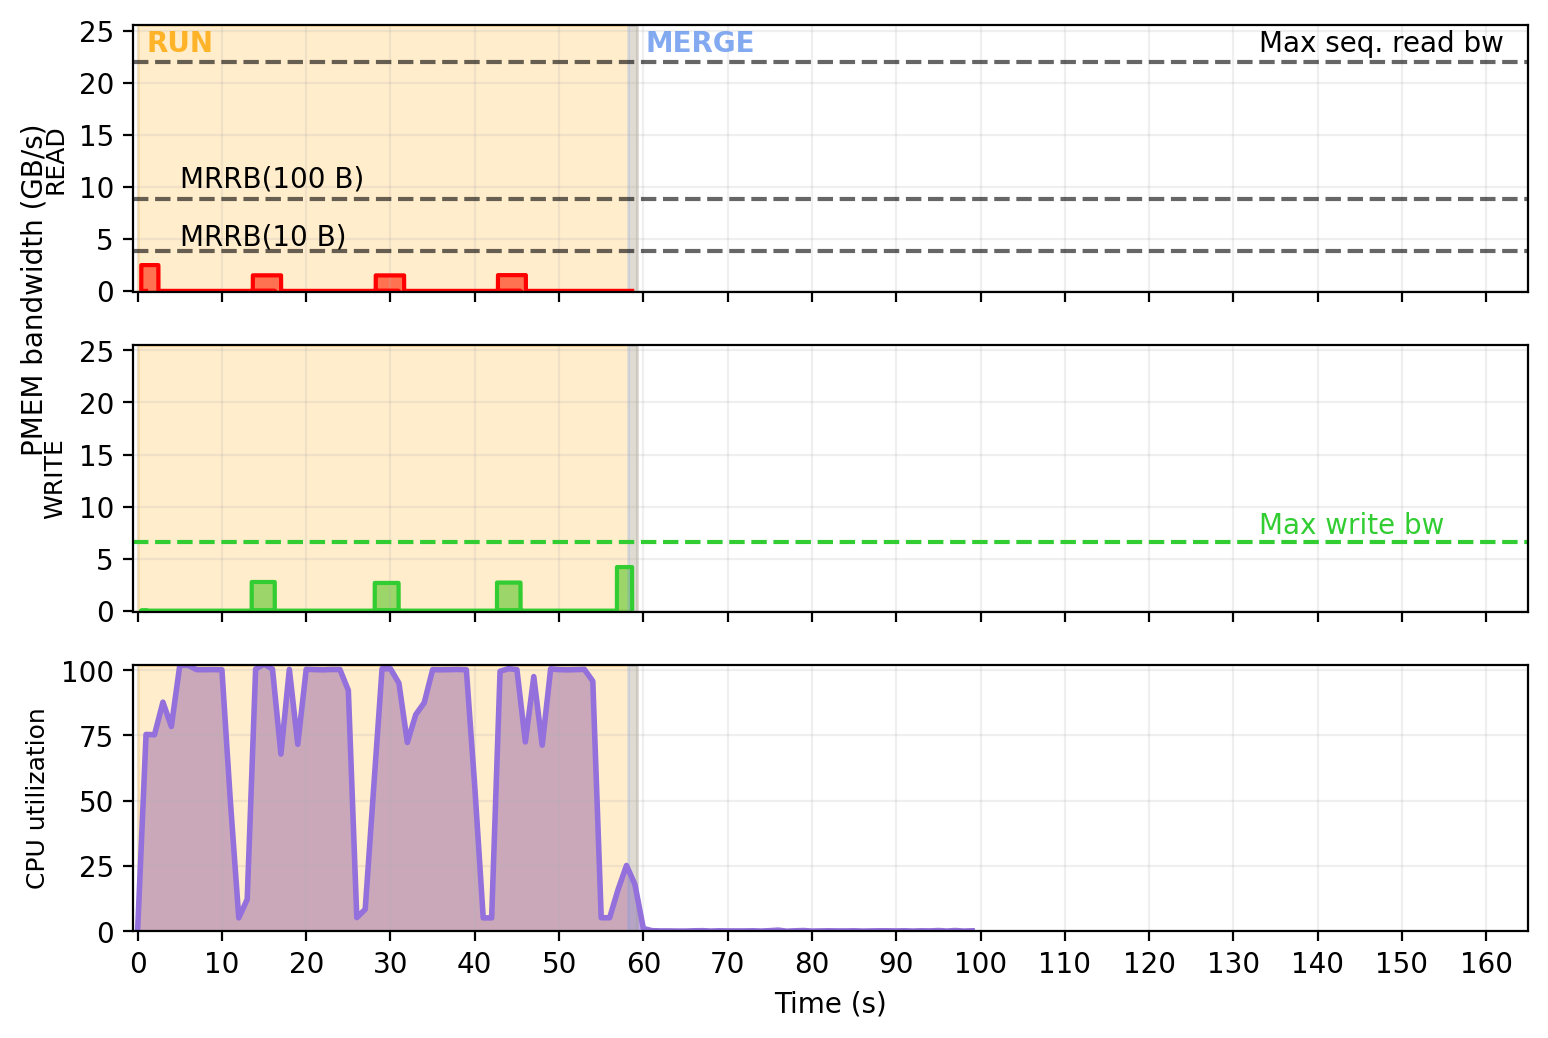

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [73]:
# wisci_io_efficiency_subplots('1')
wisci_io_efficiency_subplots('2')